# Creando Sistemas de Modelos
## Analytics y aprendizaje de máquina
#### Juan Sebastian Mosquera Cifuentes

### Bibliotecas
Se importan las librerías necesarias.

In [1]:
import os                                                           # librería para crear carpeta
import csv                                                          # Librería para importar archivo CSV
import numpy as np                                                  # Librería para realizar operaciones con python
import pandas as pd                                                 # librería de pandas para trabajar con un Dataframe                           
import pmdarima as pm                                               # Importar módulo de autoARIMA
import plotly.express as px                                         # Contiene funciones que pueden crear figuras enteras a la vez 
import statsmodels.api as sm                                        # Biblioteca que proporciona herramientas para realizar análisis estadísticos en Python
import matplotlib.pyplot as plt                                     # Módulos para utilizar gráficos
import plotly.graph_objects as go                                   # Librería para traçar e utilizar a função do indicador de nível (gauge indicator)                                
from statsmodels.tsa.stattools import kpss                          # Prueba KPSS
from statsmodels.tsa.ar_model import AutoReg                        # Para aplicar el modelo AR (Autorregresivo)
from statsmodels.tsa.stattools import adfuller                      # Prueba Dickey-Fuller
from statsmodels.tsa.arima.model import ARIMA                       # Para aplicar el modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX              # Para aplicar el modelo SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose             # Librería para generar gráfico de descomposición estacional
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf       # Gráfico de correlación
from sklearn.metrics import mean_squared_error, mean_absolute_error # Librería para calcular el error RMSE y MAE

# Bibliotecas para crear y configurar ventana
import tkinter as tk
from tkinter import *
from tkinter import ttk
from PIL import ImageTk, Image
from tkinter import Label, PhotoImage

### Datos
#### Importar la base de datos CSV

Se importa la base de datos contenida en un archivo CSV y se prepara el Time Series de tal forma que se construya un dataframe con indice temporal que tiene muestras cada minuto.

In [2]:
def cargar_y_preparar_df(archivo, columnas, renombrar, completar): # Función para cargar y preparar los DataFrames
    df = pd.read_csv(archivo, decimal=",") # Lee el archivo CSV
    df = df[columnas]  # Selecciona las columnas necesarias
    df = df.rename(columns=renombrar)  # Renombra las columnas
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convierte la columna 'Datetime' a formato DateTime
    df = df.set_index("Datetime")  # Establece 'Datetime' como índice, para que sea temporal y se construya un Time Series
    df = df.resample('T').last()  # Re-muestreo a intervalos de tiempo y toma el último valor
    df = df.fillna(method='ffill')  # Rellena los valores faltantes hacia adelante
    return df

### Exploración y limpieza de datos

Como vamos a utilizar dos archivos CSV diferentes para obtener los datos, se realiza una exploración y construcción de dos dataframes independientes que luego se unirán para formar uno final sobre el que se construirá el Time Series.

#### Cargar y preparar el Dataframe 1

Se construye el primer dataframe del archivo **db_energia.csv** que contiene una columna de referencia con la *datahora* de las muestras y otro de los valores de *demanda_instantanea_ativa*.

In [3]:
columnas_df1 = ['datahora', 'demanda_instantanea_ativa']
renombrar_df1 = {'datahora': "Datetime", 'demanda_instantanea_ativa': "Demanda"}
completar_df1 = ['Demanda']
df1 = cargar_y_preparar_df('db_energia.csv', columnas_df1, renombrar_df1, completar_df1)

#### Cargar y preparar el DataFrame 2

Se construye el segundo dataframe del archivo **db_clima.csv** que contiene las columnas de las variables exógenas *temperatura* y *umidade* que serán estudiadas y aplicadas en modelos de predicción. También utiliza una columna de referencia de *datahora* para las muestras. 

In [4]:
columnas_df2 = ['datahora', 'umidade', 'temperatura']
renombrar_df2 = {'datahora': 'Datetime', 'umidade': "Unidad", 'temperatura': "Temperatura"}
completar_df2 = ['Unidad', 'Temperatura']
df2 = cargar_y_preparar_df('db_clima.csv', columnas_df2, renombrar_df2, completar_df2)

#### Dataframe final

Luego de construir dos dataframes por separado de dos CSV diferentes, se concatenan para construir uno solo que contiene toda la información a utilizar en este informe.

In [5]:
dff = pd.concat([df1, df2], axis=1)  # Combina los DataFrames para crear uno final
dff

Demanda  Unidad  Temperatura
Datetime                                         
2023-10-02 01:42:00    19.92    98.0        13.33
2023-10-02 01:43:00    21.50    98.0        13.33
2023-10-02 01:44:00    18.56    98.0        13.33
2023-10-02 01:45:00    18.36    98.0        13.33
2023-10-02 01:46:00    18.45    98.0        13.33
...                      ...     ...          ...
2023-10-06 06:55:00    25.88    93.0        20.00
2023-10-06 06:56:00    23.47    93.0        20.00
2023-10-06 06:57:00    25.88    93.0        20.00
2023-10-06 06:58:00    25.88    94.0        20.00
2023-10-06 06:59:00    28.91    94.0        20.00

[6078 rows x 3 columns]

#### Primera gráfica
Se crea la primera gráfica obtenida con todos los datos extraídos.

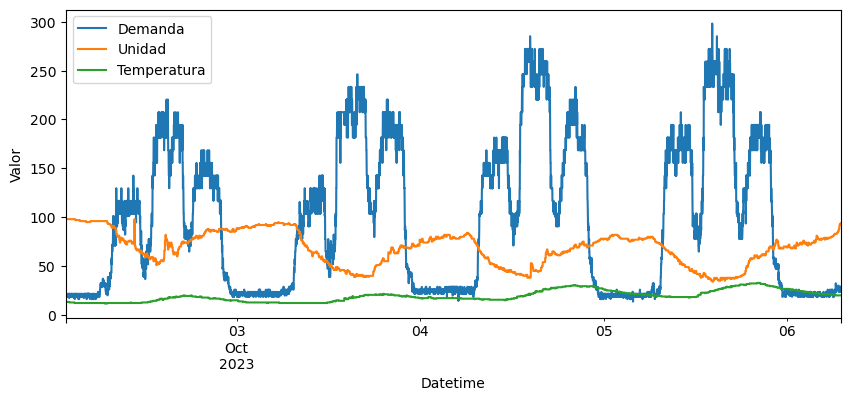

In [6]:
dff.plot(kind='line', figsize=(10, 4))  # Se gráfica el dataframe final que contiene toda la información extraída
plt.xlabel("Datetime")
plt.ylabel("Valor")
plt.show()

Aquí se encuentra toda la información obtenido en un dataframe final **dff** que tiene 3 variables contenidas en 3 columnas *Demanda*, *Temperatura* y *Unidad* con muestras cada minuto y con 6078 datos por cada una.

#### Se modifican las muestras de los datos horariamente

Se construye un nuevo dataframe que va a contener información de todos los datos con muestras cada hora. Con esto se logra una reducción considerable de los datos. 

In [7]:
dataframe = dff.resample('H').last()
columns_to_fill = ['Demanda', 'Unidad', 'Temperatura']
dataframe

Demanda  Unidad  Temperatura
Datetime                                         
2023-10-02 01:00:00    18.56    98.0        13.33
2023-10-02 02:00:00    18.54    97.0        12.22
2023-10-02 03:00:00    18.55    96.0        12.22
2023-10-02 04:00:00    18.56    96.0        12.22
2023-10-02 05:00:00    21.78    96.0        12.22
...                      ...     ...          ...
2023-10-06 02:00:00    23.50    72.0        22.78
2023-10-06 03:00:00    19.92    78.0        21.67
2023-10-06 04:00:00    20.01    78.0        21.11
2023-10-06 05:00:00    19.91    81.0        20.56
2023-10-06 06:00:00    28.91    94.0        20.00

[102 rows x 3 columns]

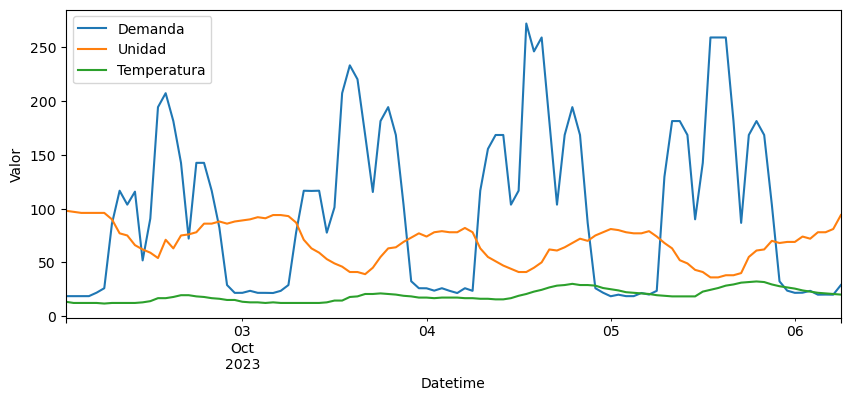

In [8]:
dataframe.plot(kind='line', figsize=(10, 4)) # Gráfica con muestras horariamente
plt.xlabel("Datetime")
plt.ylabel("Valor")
plt.show()

Como se observa se logró una reducción de datos donde se pasó de tener 6078 por cada una de las tres columnas a tan sólo 102. Nos damos cuenta de que se mantienen algunos patrones o características de estacionaildad y de tendencia. Para estudiar diferentes modelos podemos trabajar con estos datos, ya que nos permite reducir el gasto computacional y probar los modelos rápidamente. Esto sólo nos permite conocer de forma general algunos modelos de predicción sin entrar en mucho detalle como en un caso real en el que se trabajan con millones de datos.

In [9]:
if not os.path.exists("images"):  # Se crea una carpeta donde se guardarán algunas imágenes del estudio
    os.mkdir("images")

# Modelos de predicción
Aquí se aplican diferentes modelos de predicción con los datos obtenidos previamente.

#### Selección del dataframe
Como se crearon dos dataframes se puede trabajar con cualquiera, para elegir trabajar con alguno seleccione entre:
##### - dff:
Dataframe con muestras cada minuto.
##### - dataframe: 
Dataframe con muestras cada hora.

In [10]:
seleccion = "dataframe" # Sólo seleccione dff o dataframe dentro de las comillas ("") según los datos con los que quiere trabajar 

#### Características de los modelos de acuerdo al dataframe

Se definen algunos prámetros dependiendo del dataframe que seleccione.

In [11]:
if seleccion == "dataframe":
    df = dataframe 
    muestras = 24
    f='H'
    print("Estás trabajando con 'dataframe' que tiene muestras cada hora.")
else:
    df = dff 
    muestras = 1440
    f='T'
    print("Estás trabajando con 'dff' que tiene muestras cada minuto.")

Estás trabajando con 'dataframe' que tiene muestras cada hora.


# Modelos Autoregresivos

#### Figura con los datos a utilizar
Se grafica el dataframe (TimeSeries) de forma dinámica con los datos seleccionados.

In [12]:
fig = px.line(df, y=['Demanda'], title='Demanda Instantánea Activa').update_layout(xaxis_title="Datetime", yaxis_title="Valor")
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(buttons=list([dict(step="all")])))
fig.show()

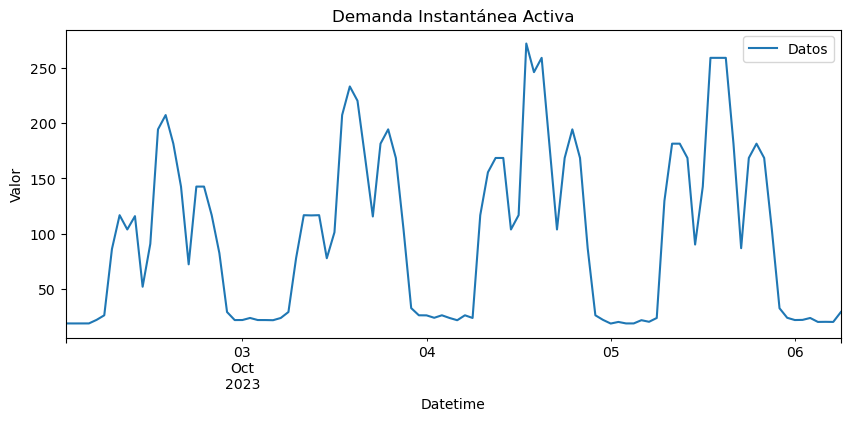

In [13]:
df["Demanda"].plot(kind='line', figsize=(10, 4), label="Datos", legend="True")  # Se crea la primera gráfica con los datos a trabajar
plt.title("Demanda Instantánea Activa")
plt.xlabel("Datetime")
plt.ylabel("Valor")
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\imagenOriginal1.png")
plt.show()

#### Descripción de los datos

In [14]:
df["Demanda"].describe()

count    102.000000
mean      98.823137
std       76.548945
min       18.450000
25%       23.500000
50%       90.375000
75%      168.480000
max      272.160000
Name: Demanda, dtype: float64

# Pruebas de estacionalidad y estacionariedad

- Método gráfico
- Método teórico

### Método gráfico

#### Descomposición estacional
Como un modelo autorregresivo tiene la característica de ser un tipo de regresión lineal y funciona con patrones estacionales, primero vemos la descomposición estacional de los datos con la función seasonal_decompose que nos permiten ver sus componentes (tendencia, estacionalidad y ruido) y de esta manera ver la naturaleza de nuestros datos en función sus registros pasados.

El modelo aditivo es útil cuando la variación estacional es relativamente constante en el tiempo.

El modelo multiplicativo es útil cuando la variación estacional aumenta con el tiempo.

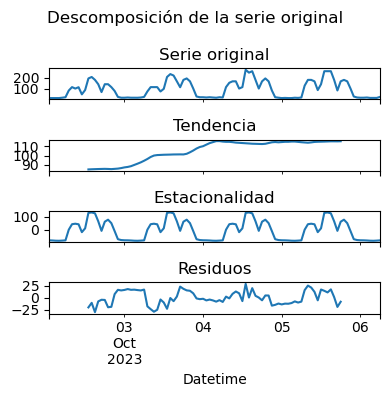

In [15]:
decomposition1 = seasonal_decompose(df['Demanda'], period=muestras)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 4), sharex=True)
decomposition1.observed.plot(ax=axs[0])
axs[0].set_title('Serie original')
decomposition1.trend.plot(ax=axs[1])
axs[1].set_title('Tendencia')
decomposition1.seasonal.plot(ax=axs[2])
axs[2].set_title('Estacionalidad')
decomposition1.resid.plot(ax=axs[3])
axs[3].set_title('Residuos')
fig.suptitle('Descomposición de la serie original')
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\decomposeOriginal.png")
fig.tight_layout()

Desde aquí ya podemos visualizar algunas características de nuestros datos que nos dan información importante. Visualizamos de que los datos tienen una tendencia a aumentar pero no es tan pronunciable. Además, de que sí posee estacionalidad y se repite cierta forma en un período de 24 horas (para el dataframe con muestras horarias), mientras que un período de 1440 muestras (para el dataframe con datos cada minuto) ambos con patrón diario. Podemos pensar de que su media y varianza es constante el tiempo ya que no existen alteraciones considerables en los datos que vemos en las gráficas a través del tiempo, sin embargo, podemos confirmar esta teoría con pruebas de estacionareidad.

### Método teórico
Augmented Dicky-Fuller test (ADF) y Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

#### Prueba ADF

Hipótesis nula: La serie tiene una raíz unitaria, significa que es no estacionaria. Tiene alguna estructura dependiente del tiempo. 

Hipótesis alterna: La serie no tiene raíz unitaria, significa que es estacionaria. No tiene una estructura dependiente del tiempo. 

ADF test:  Con un p-value <= 0.05 la hipótesis nula es rechazada. Si se rechaza la hipótesis nula, esta prueba puede proporcionar evidencia de que la serie es estacionaria.

In [16]:
def adf_test(series, column_name):  # Función de la prueba ADF 
    print (f'Resultados de la prueba de Dickey-Fuller para la columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechaza la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [17]:
adf_test(df["Demanda"], "Demanda")

Resultados de la prueba de Dickey-Fuller para la columna: Demanda
Test Statistic                        -3.362995
p-value                                0.012287
No Lags Used                          13.000000
Número de observaciones utilizadas    88.000000
Critical Value (1%)                   -3.506944
Critical Value (5%)                   -2.894990
Critical Value (10%)                  -2.584615
dtype: float64
Conclusion:====>
Rechaza la hipótesis nula
Los datos son estacionarios


#### Prueba KPSS

Hipótesis nula: El proceso tiene tendencia estacionaria.

Hpótesis alternativa: La serie tiene una raíz unitaria (La serie es no estacionaria).

KPSS test: Con un p-value <= 0.05 la hipótesis nula se rechaza a favor de la alternativa. Por tanto, evidencia que la serie no es estacionaria.

In [18]:
def kpss_test(timeseries, column_name):  # Función de la prueba KPSS
    print (f'Resultados de la prueba de KPSS para la columna: {column_name}')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpsstest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos no son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos son estacionarios")

In [19]:
kpss_test(df["Demanda"], "Demanda")

Resultados de la prueba de KPSS para la columna: Demanda
Test Statistic           0.079733
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos son estacionarios


C:\Users\juanm\AppData\Local\Temp\ipykernel_10736\470410012.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




#### Resumen de las pruebas ADF y KPSS

Se construye una tabla resumen que muestras los resultados de las pruebas ADF y KPSS, y si estos resultados indican estacionareidad o no. De esta forma, concluye si la serie es estacionaria y el grado de diferenciación necesario para que lo sea.

In [20]:
def obtain_adf_kpss_results(timeseries, max_d): 
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <= 0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <= 0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
        results_df = pd.DataFrame(results, columns=['p_value_adf','p-value_kpss', 
                                'is_adf_stationary','is_kpss_stationary','is_stationary' ])  # Construct DataFrame 
    
    return results_df

In [21]:
obtain_adf_kpss_results(df["Demanda"], 2)

C:\Users\juanm\AppData\Local\Temp\ipykernel_10736\2967474787.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\juanm\AppData\Local\Temp\ipykernel_10736\2967474787.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




p_value_adf  p-value_kpss  is_adf_stationary  is_kpss_stationary  \
0     0.012287           0.1               True                True   
1     0.000019           0.1               True                True   

   is_stationary  
0           True  
1           True

Siempre es mejor aplicar ambas pruebas, para poder asegurar de que la serie es verdaderamente estacionaria. Los posibles resultados de la aplicación de estas pruebas estacionarias son los siguientes:

**Caso 1:** Ambas pruebas concluyen que la serie no es estacionaria. Por lo tanto, la serie no es estacionaria.

**Caso 2:** Ambas pruebas concluyen que la serie es estacionaria. Por lo tanto, la serie es estacionaria.

**Caso 3:** KPSS indica estacionariedad y ADF indica no estacionariedad. La serie es de tendencia estacionaria. Es necesario eliminar la tendencia para que las series sean estrictamente estacionarias. Se comprueba la estacionariedad de la serie sin tendencia.

**Caso 4:** KPSS indica no estacionariedad y ADF indica estacionariedad. La serie es estacionaria en diferencias. La diferenciación se utilizará para hacer que las series sean estacionarias. Se comprueba la estacionariedad de la serie diferenciada.

Para este ejemplo, tenemos el caso 2 en que ambas pruebas indican que la serie es estacionaria. Esto no ocurre muchas veces y es necesario aplicar métodos de diferenciación o de eliminación de tendencias. 

## Transformaciones de series

#### Convertir la serie en estacionaria
Como se mencionó, en muchos casos los test indican que la serie no es estacionaria y por lo tanto, es necesario convertirla ya que los modelos regresivos comparten esta característica para poder construir modelos de predicción. Este no es el caso, sin embargo, se muestra cómo hacerlo en caso de que se requiera. 

En este link de IBM se define y se explica detalladamente la importancia de la transformación de series para los modelos ARIMA, sus tipos y cuándo utilizarlos. Para más información visitar [Transformaciones de series](https://www.ibm.com/docs/es/spss-modeler/saas?topic=data-series-transformations).

### Método de diferenciación

Aquí se aplica la función *diff* que constituye a un tipo de diferenciación simple y funciona como transformación de una serie para la estabilización de nivel.

In [22]:
diferenciada = df["Demanda"].diff().dropna()  # Se crea una nueva serie diferenciada

Este método de diferenciación calcula las diferencias existentes entre cada valor y el anterior de la serie, a excepción del valor más antiguo de la serie. Por tanto, la serie diferenciada tendrá un valor menos que la serie original.

#### Descomposición estacional para la serie diferenciada

In [23]:
decomposition2 = seasonal_decompose(diferenciada, period=muestras)  # Descomposición estacional de la serie diferenciada

#### Gráfica de la primera diferenciación de la serie y su descomposición estacional
Aquí se presenta un sólo gráfico con la serie original y sus componentes estacionales junto con la primera diferenciación y sus componentes  para realizar una comparación.

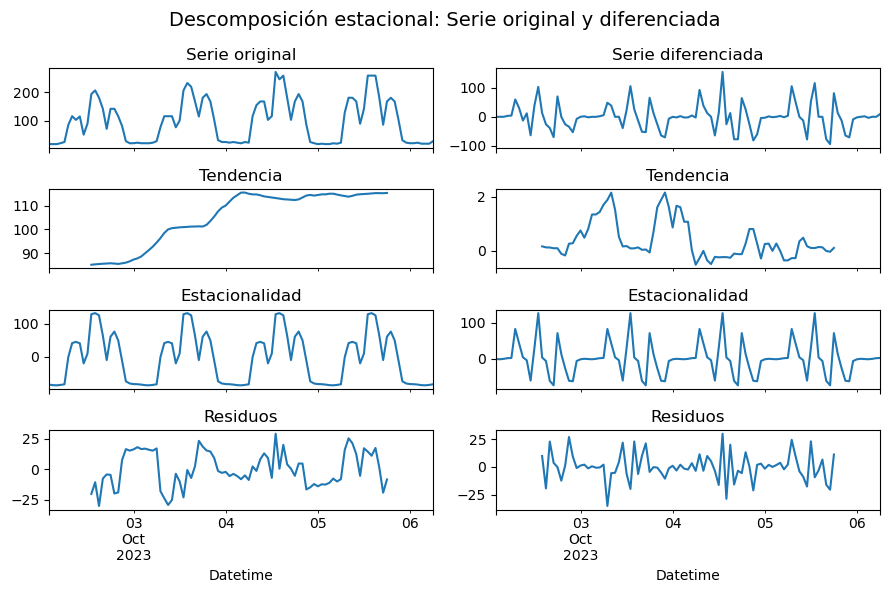

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
decomposition1.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
decomposition1.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
decomposition1.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
decomposition1.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
decomposition2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Serie diferenciada')
decomposition2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
decomposition2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
decomposition2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición estacional: Serie original y diferenciada', fontsize=14)
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\seasonalDecompose.png")
fig.tight_layout();

Observando los componentes de la serie diferenciada podemos ver de que sigue su patrón estacional y se "normaliza" para que la media se encuentre en cero. La tendencia se reduce ya que no parece sólo aumentar como se ve en la imagen izquierda y sus valores sólo oscilan entre 0 y 2 aproximadamente. Al parecer se logra eliminar una posible tendencia estocástica que existe en la serie original.

### Método de logaritmo

Otro tipo de transformación es la del método de logaritmo con la funcion *log* y sirve como de estabilización de la varianza.

<Axes: xlabel='Datetime'>

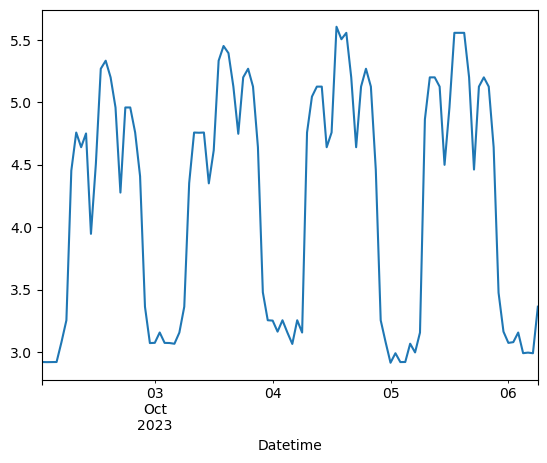

In [25]:
df_log = np.log(df)
df_log["Demanda"].plot()

In [26]:
adf_test(df_log["Demanda"], "Demanda")

Resultados de la prueba de Dickey-Fuller para la columna: Demanda
Test Statistic                       -8.162202e+00
p-value                               9.080213e-13
No Lags Used                          1.300000e+01
Número de observaciones utilizadas    8.800000e+01
Critical Value (1%)                  -3.506944e+00
Critical Value (5%)                  -2.894990e+00
Critical Value (10%)                 -2.584615e+00
dtype: float64
Conclusion:====>
Rechaza la hipótesis nula
Los datos son estacionarios


Por las características de nuestra señal el método del logaritmo para transformar la serie y convertirla en estacionaria no es tan visible como la del método de diferenciación. A pesar de que se sigue cumpliendo estacionariedad, se trabajará solamente con la diferenciación de primer grado cuando se requiera.

## Plot ACF y Plot PACF

Las gráficas ACF (Función de Autocorrelación) y PACF (Función de Autocorrelación Parcial) son herramientas utilizadas en estadísticas y análisis de series temporales para analizar patrones de autocorrelación en un conjunto de datos. Estas gráficas son especialmente útiles en el contexto de modelado y pronóstico de series temporales, donde se busca comprender y modelar la dependencia temporal de los datos. Esto sirve para hallar AR y MA, que corresponden a p y q del modelo ARIMA.

La ACF mide la correlación entre una serie de datos y versiones rezagadas de sí misma en diferentes retardos o intervalos de tiempo.

La PACF mide la correlación entre una serie de datos y versiones rezagadas de sí misma, pero elimina el efecto de las autocorrelaciones en retardos intermedios.

#### ACF y PACF de la serie original

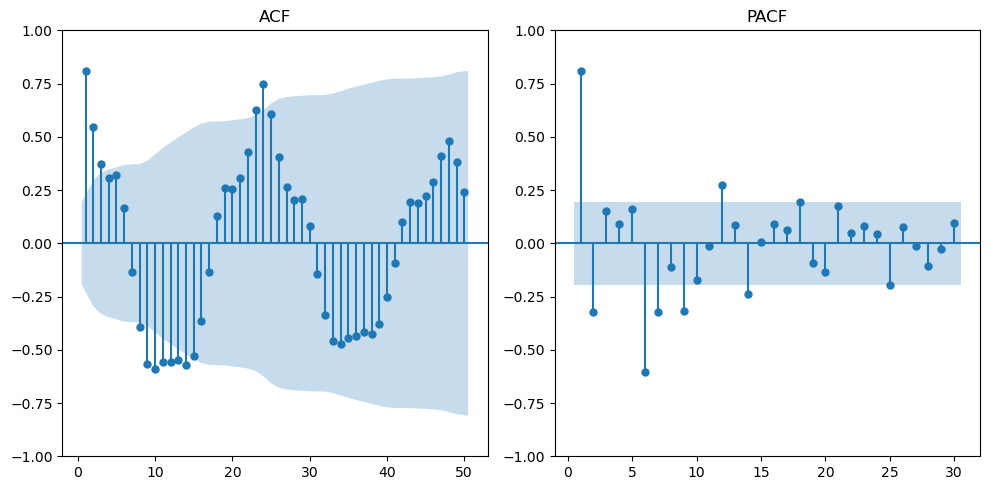

In [27]:
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})
fig, axes = plt.subplots(1, 2, sharex=False)

plot_acf(df["Demanda"], lags=50, ax=axes[0], zero=False); axes[0].set_title('ACF')  # Autocorrelación

plot_pacf(df["Demanda"], lags=30, ax=axes[1], zero=False); axes[1].set_title('PACF')  # Autocorrelación Parcial

plt.tight_layout()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotACFePACFOriginal.png")
plt.show()

Aanlizando las gráficas de ACF y PACF podemos realizar varias observaciones:
- Si la función de autocorrelación (ACF) decae lentamente y de manera continua, en lugar de mostrar picos significativos que te ayuden a identificar los órdenes p (autoregresivo) y q (media móvil) es recomendable bucar otros modelos de predicción. Sin embargo, en este caso donde el ACF cae gradualmente se usa el modelo AR, y observamos la gráfica de PACF para determinar p. En este caso alcanzamos a ver un último valor en la gráfica de PACF que alcanza a sobrepasar la línea de siginificancia (p=24), de igual forma en la gráfica ACF se puede observar que el último valor que sobrepasa la línea de significancia, puede indicarnos algo.

#### ACF y PACF de la serie diferenciada

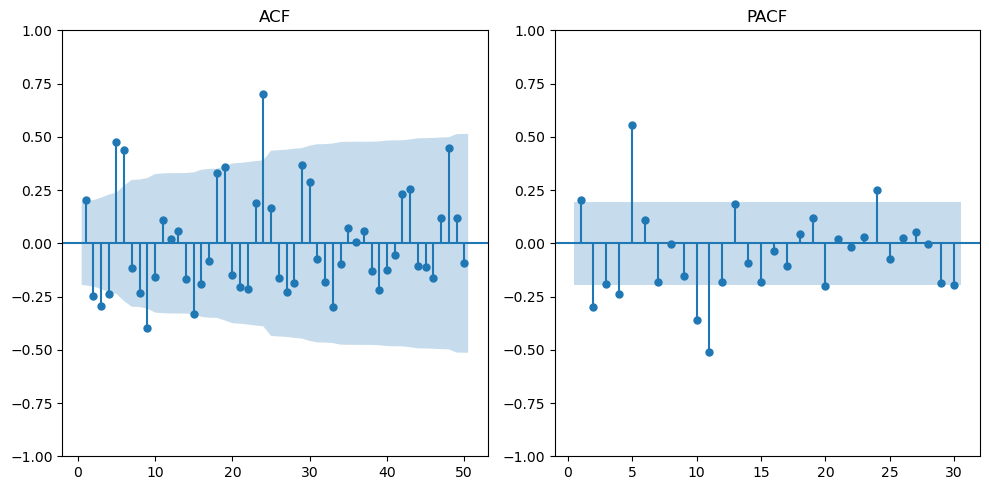

In [28]:
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})
fig, axes = plt.subplots(1, 2, sharex=False)

plot_acf(df["Demanda"].diff().dropna(), lags=50, ax=axes[0], zero=False); axes[0].set_title('ACF')  # Autocorrelación

plot_pacf(df["Demanda"].diff().dropna(), lags=30, ax=axes[1], zero=False); axes[1].set_title('PACF')  # Autocorrelación Parcial

plt.tight_layout()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotACFePACFDiferenciada.png")
plt.show()

#### Gráfico de autocorrelación y autocorrelación parcial de la seria original y su primera diferenciación

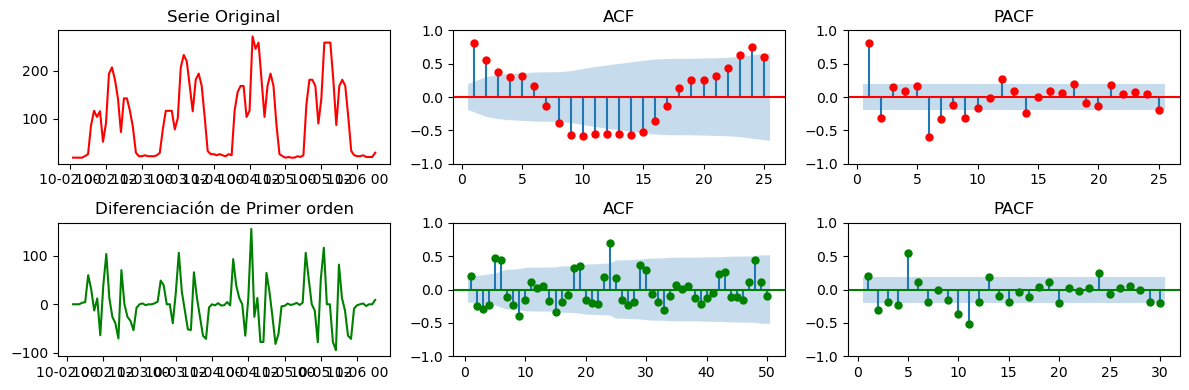

In [29]:
plt.rcParams.update({'figure.figsize': (12, 4), 'figure.dpi': 100})
fig, axes = plt.subplots(2, 3, sharex=False)    

axes[0, 0].plot(df["Demanda"],color="r"); axes[0, 0].set_title('Serie Original')  # Serie Original
plot_acf(df["Demanda"], lags=25, ax=axes[0, 1], zero=False, color="r"); axes[0, 1].set_title('ACF')
plot_pacf(df["Demanda"], lags=25,  ax=axes[0, 2], zero=False, color="r"); axes[0, 2].set_title('PACF')

axes[1, 0].plot(df["Demanda"].diff(), color="g"); axes[1, 0].set_title("Diferenciación de Primer orden")  # Primera diferenciación 
plot_acf(df["Demanda"].diff().dropna(), lags=50, ax=axes[1, 1], zero=False, color="g"); axes[1, 1].set_title('ACF')
plot_pacf(df["Demanda"].diff().dropna(), lags=30, ax=axes[1, 2], zero=False, color="g"); axes[1, 2].set_title('PACF')

plt.tight_layout()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotACFePACF.png")
plt.show()

horario (2,0,3), (3,0,4), (5,1,6), (6,1,7), autoarima m=0 (ARIMA(1,0,0)(1,0,1)(24)
cada minuto (4,0,198), (5,0,199), (3,1,1), (4,1,2)

AR(2)
MA(3)
ARMA(2,3)

#### Selección de datos de entrenamiento y prueba

Se definen intervalos de datos que constituyen los de entrenamiento y los de testeo.

In [30]:
size = int(len(df)*0.68)  # Selección del porcentaje del tamaño en que se dividirán los datos de entrenamiento y testeo

##### Datos de entrenamiento y de prueba de la serie original

In [31]:
train = df [(df.index.get_level_values(0) >= df.index[0]) & (df.index.get_level_values(0) <= df.index[size])]  # Entrenamiento
test = df [(df.index.get_level_values(0) > df.index[size])]  # Testeo

In [32]:
# train.plot()  # Gráfica de los datos de entrenamiento
# test.plot()  # Gráfica de los datos de testeo

##### Datos de entrenamiento y de prueba de la serie diferenciada
A pesar de que se comprobó la estacionareidad se forma un conjunto de datos de entrenamiento de la serie diferenciada para realizar aalgunas pruebas en modelos de predicción.

In [33]:
train_dif = diferenciada [(diferenciada.index.get_level_values(0) >= diferenciada.index[0]) & (diferenciada.index.get_level_values(0) <= diferenciada.index[size])]  # Entrenamiento
test_dif = diferenciada [(diferenciada.index.get_level_values(0) > diferenciada.index[size])]  # Testeo

In [34]:
# train_dif.plot()
# test_dif.plot()

# Modelo AR
Un modelo AR (AutoRegresivo) es una técnica de modelado de series temporales que se basa en la idea de que los valores futuros de la serie temporal se pueden predecir en función de sus valores pasados. Será nuestro primer objeto de estudio hasta analizar otros más complejos más adelante.

Como el modelo AR toma como referencia la correlación de los valores pasados para predecir los valores futuros, primero vamos a probar con restrasos de acuerdo al periodo de sus muestras, es decir, 24 o 1440 dependiendo del dataframe.

In [35]:
modeloAR = AutoReg(train["Demanda"], lags=muestras).fit()  # Se aplica el modelo AR 
modeloAR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                Demanda   No. Observations:                   70
Model:                    AutoReg(24)   Log Likelihood                -180.654
Method:               Conditional MLE   S.D. of innovations             12.284
Date:                Thu, 26 Oct 2023   AIC                            413.308
Time:                        15:34:12   BIC                            460.852
Sample:                    10-03-2023   HQIC                           431.118
                         - 10-04-2023                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.1884     18.821      1.126      0.260     -15.700      58.077
Demanda.L1      0.2455      0.133      1.852      0.064      -0.014       0.505
Demanda.L2      0.2446      0.133      1.834      0.067      -0.017       0.506
Demanda.L3      0.0436      0.140      0.311      0.756      -0.231       0.318
Demanda.L4     -0.2856      0.140     -2.038      0.042      -0.560      -0.011
Demanda.L5      0.2801      0.142      1.976      0.048       0.002       0.558
Demanda.L6      0.2417      0.142      1.706      0.088      -0.036       0.519
Demanda.L7     -0.4045      0.144     -2.818      0.005      -0.686      -0.123
Demanda.L8     -0.3088      0.156     -1.985      0.047      -0.614      -0.004
Demanda.L9      0.2471      0.162      1.521      0.128      -0.071       0.565
Demanda.L10     0.1367      0.179      0.763      0.446      -0.215       0.488
Demanda.L11    -0.3318      0.184     -1.801      0.072      -0.693       0.029
Demanda.L12     0.0432      0.188      0.230      0.818      -0.325       0.412
Demanda.L13     0.2916      0.177      1.643      0.100      -0.056       0.639
Demanda.L14    -0.0884      0.179     -0.493      0.622      -0.440       0.263
Demanda.L15    -0.1677      0.175     -0.958      0.338      -0.511       0.175
Demanda.L16     0.0106      0.174      0.061      0.951      -0.330       0.351
Demanda.L17     0.1430      0.176      0.815      0.415      -0.201       0.487
Demanda.L18    -0.1203      0.160     -0.752      0.452      -0.434       0.193
Demanda.L19     0.2615      0.159      1.642      0.101      -0.051       0.574
Demanda.L20    -0.2592      0.160     -1.623      0.105      -0.572       0.054
Demanda.L21     0.1250      0.160      0.783      0.433      -0.188       0.438
Demanda.L22    -0.1661      0.161     -1.029      0.303      -0.482       0.150
Demanda.L23     0.1938      0.159      1.219      0.223      -0.118       0.505
Demanda.L24     0.4998      0.150      3.333      0.001       0.206       0.794
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0084           -0.0000j            1.0084           -0.0000
AR.2             0.9586           -0.2593j            0.9930           -0.0421
AR.3             0.9586           +0.2593j            0.9930            0.0421
AR.4             0.8893           -0.4740j            1.0078           -0.0779
AR.5             0.8893           +0.4740j            1.0078            0.0779
AR.6             0.7466           -0.7163j            1.0347           -0.1217
AR.7             0.7466           +0.7163j            1.0347            0.1217
AR.8             0.4980           -0.8606j            0.9943           -0.1665
AR.9             0.4980           +0.8606j           

In [36]:
predsAR = modeloAR.model.predict(modeloAR.params, start=test.index.min(), end=test.index.max())  # Comparan predicción con testeo

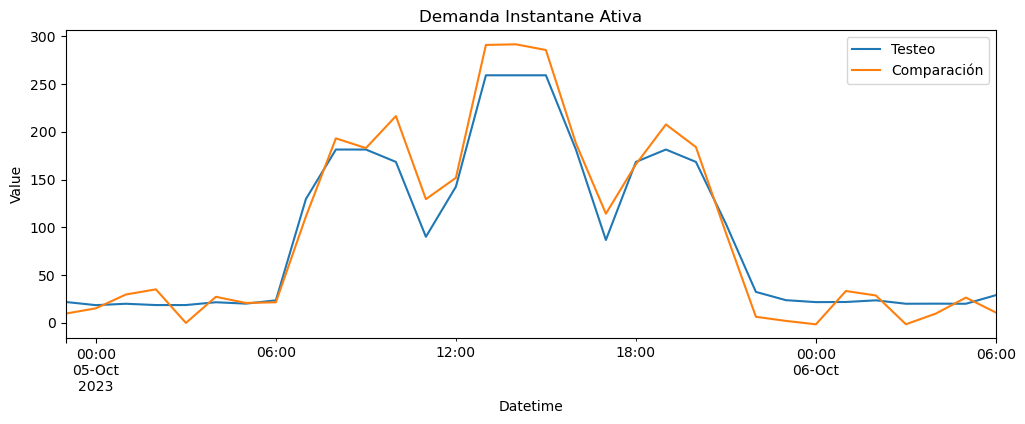

In [37]:
test["Demanda"].plot(label="Testeo")  # Gráfica
predsAR.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotComAR.png")

In [38]:
rmseAR = np.sqrt(mean_squared_error(test["Demanda"], predsAR))  # Cálculo del RMSE
maeAR = mean_absolute_error(test["Demanda"], predsAR)  # Cálculo del MAE

print(f'RMSE: {rmseAR}')
print(f'MAE: {maeAR}')

RMSE: 19.936037242139967
MAE: 16.247040650123047


In [39]:
forecastAR=modeloAR.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

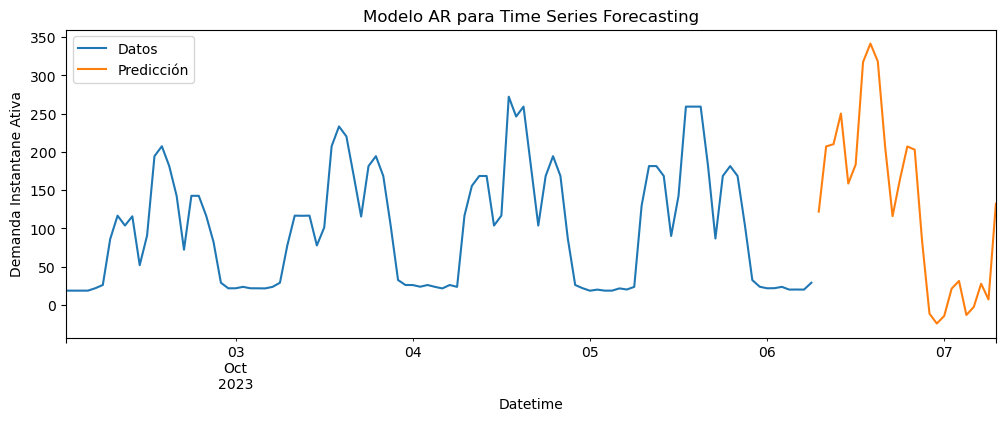

In [40]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAR.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForAR.png")

In [41]:
df_resultsAR = pd.DataFrame(columns=['Modelo', 'Parámetros', 'AIC', 'BIC', 'RMSE', 'MAE'])

fila_AR = {
    'Modelo': 'modeloAR',
    'Parámetros': 'p=24',
    'AIC': modeloAR.aic,
    'BIC': modeloAR.bic,
    'RMSE': rmseAR,
    'MAE': maeAR
}

nueva_fila_df = pd.DataFrame([fila_AR])
df_resultsAR = pd.concat([df_resultsAR, nueva_fila_df], ignore_index=True)

df_AR = df_resultsAR.sort_values(by='RMSE').round(2)
df_AR

Modelo Parámetros     AIC     BIC   RMSE    MAE
0  modeloAR       p=24  413.31  460.85  19.94  16.25

## Diagnosis

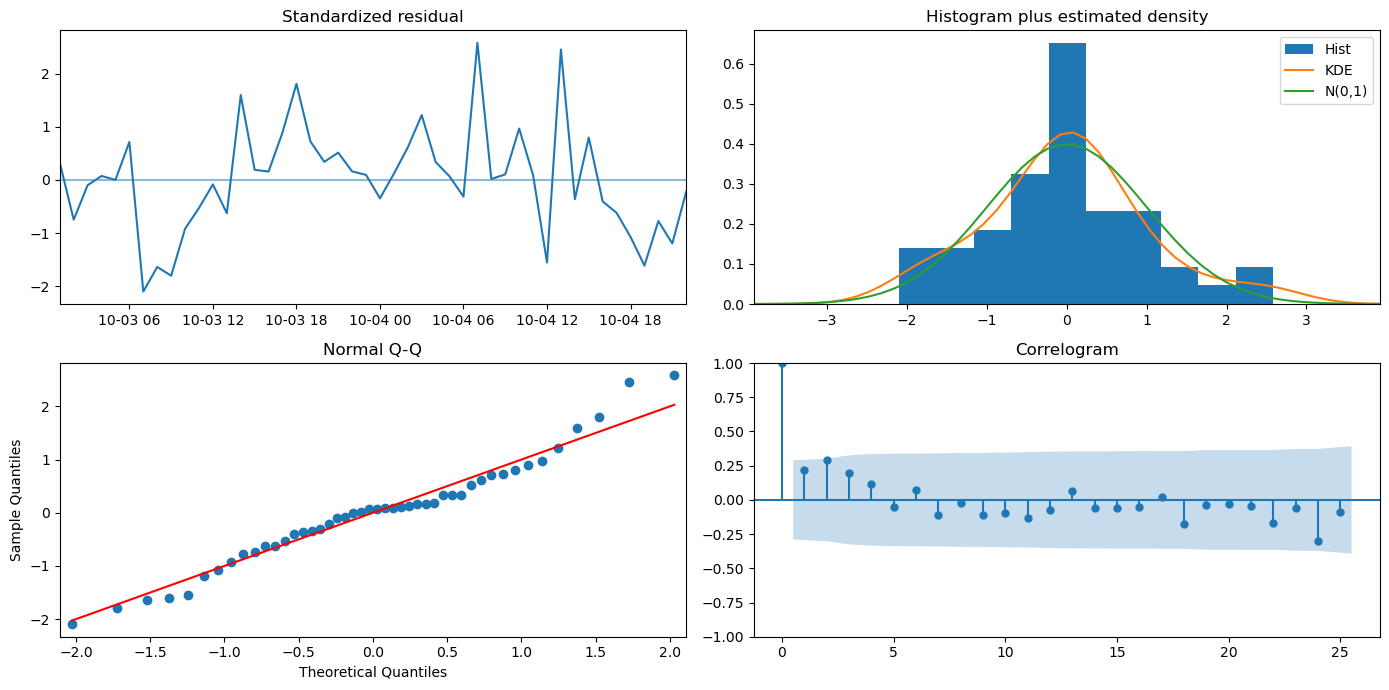

In [42]:
modeloAR.plot_diagnostics(lags=25, figsize=(14, 7))
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsAR.png")
plt.tight_layout()
plt.show()

Ya vimos que la correlación que existe en los datos pasados puede determinar el valor de los datos futuros como lo hace el modelo AR. Según la grafica de ACF y PACF de la serie original vimos varios picos fuera de la banda d esignificancia que indica los valores que debemos a tener en cuenta. Se realizó pruebas con cada uno de ellos y se observó cuan AR(24) es donde existe una mayor predicción y error de los datos, lo cual tiene sentido con el patron diario y las muestras horarias con las que se está trabajando.

- Gráfico de Residuos vs. Valores Ajustados: Los residuos se distribuyen aleatoriamente alrededor de cero: Esto indica que la linealidad y la independencia de errores se mantienen. No deberías ver ningún patrón obvio.
- Gráfico Q-Q de los Residuos: Los puntos siguen aproximadamente una línea diagonal: Esto sugiere que los residuos siguen una distribución normal y cumplen con la suposición de normalidad.
- En la práctica las colas pesadas ("fat tails") implican que existe mayor probabilidad de obtener valores extremos (observaciones alejadas muy alegadas de la media) que la que existiría en una distribución normal.
- Los residuos son las diferencias entre los valores observados y los valores predichos por el modelo. Un correlograma de residuos te permite analizar si los residuos están correlacionados en el tiempo, lo que puede indicar problemas no capturados por el modelo. Como a diferencia de 0 que siempre es 1, podemos ver de que los residuos no salen d ela línea de significancia lo que es bueno ya que los residuos deberían ser ruido blanco, es decir, no deberían mostrar patrones de autocorrelación.

Otras observaciones son:
- Se comprobó con diferentes lags para el modelo AR y la que presentó menor RMSE y MAE es el de 24. Con valores menores de 5 se observa una constante. Con valores mayores a 5 y menores a 9 se observan pequeñas oscilaciones. Con 9 y valores hasta 13 se ve una detección de picos obteniendo una señal parecida a senosoidal. Con valores mayores empieza a intentar tomar la forma de los datos hasta encontrar su mejor modelo 24 y llegar hasta 30 para luego sólo arrojar valores anormales.

#### Funciones para crear Gauge y la figura indicadora

In [43]:
def percent(last_number, meta):
    if meta == 0:     # Verificar si la meta es 0 para evitar una posible división por cero
        return 0.0
    else:
        percent = round(last_number * 100 / meta, 2)  # Calcular el porcentaje y redondearlo a dos decimales
        return percent

In [44]:
def crear_figura_gauge(last_number, meta):
    percent = round(last_number * 100 / meta, 2)

    fig1 = go.Figure(layout=go.Layout(annotations=[
        go.layout.Annotation(
            text=str(percent) + '%',
            font=font,
            showarrow=False,
            x=0.5, y=-0.1,
        )
    ]))

    fig1.add_trace(go.Indicator(
        mode="gauge+number",
        number={'valueformat': '.2f'},
        value=last_number,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': title, 'font': font},
        gauge={
            'axis': {'range': [None, 500], 'tickwidth': 1, 'tickcolor': "darkblue"},
            'bar': {'color': "darkblue"},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
            'steps': [
                {'range': [0, 300], 'color': "cyan"},
                {'range': [300, 450], 'color': "royalblue"}
            ],
            'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 1, 'value': meta}
        }
    ))
    return fig1

In [45]:
def crear_figura_tendencia(valor_predito, last_number):
    fig1 = go.Figure()

    if valor_predito > last_number:
        fig1.add_shape(
            go.layout.Shape(
                type="path",
                path="M 1 0 L 4 0 L 2.5 3 Z",
                fillcolor='green',
                opacity=0.7,
                layer='above',
                line_width=0
            )
        )
    elif valor_predito < last_number:
        fig1.add_shape(
            go.layout.Shape(
                type="path",
                path="M 1 3 L 4 3 L 2.5 0 Z",
                fillcolor='red',
                opacity=0.7,
                layer='above',
                line_width=0
            )
        )
    else:
        fig1.add_shape(
            type="rect",
            x0=1, y0=1, x1=4, y1=2,
            line=dict(color="gray", width=1),
            layer='above',
            fillcolor="gray"
        )

    fig1.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
    fig1.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)
    fig1.update_layout(plot_bgcolor="white")

    return fig1

In [46]:
meta = 400  # Valor da meta prevista (Cambiar)
last_number = df["Demanda"][-1]  # Número a comparar para generar el indicador de tendencia de subida

In [47]:
font = {#'family': 'Droid Sans',  # Se pretender alterar o estilo, 
        'color':  'darkblue',  # O tamanho
        'size': 26}  # E a cor do tipo de letra

## Creación del Gauge Chart 1

### Datos 1

In [48]:
valor_predito = forecastAR[0]  # Se toma el primer dato de predicción futura

In [49]:
title = "AR["+str(muestras)+"](Demanda Instantânea Ativa)"
figura = crear_figura_gauge(last_number, meta)
figura.show()
figura.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeAR.png")

In [50]:
figura_tendencia = crear_figura_tendencia(valor_predito, last_number)
figura_tendencia.show()
figura_tendencia.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigAR.png")

# Modelo MA
La media móvil es una técnica estadística utilizada para analizar datos temporales o secuenciales. La idea detrás de la media móvil es suavizar los datos al calcular promedios de valores en un período de tiempo determinado. La "media" en "media móvil" se refiere al promedio.

#### Suavizar los datos
En este enfoque, se calcula el promedio de un conjunto fijo de puntos de datos dentro de una ventana deslizante. A medida que avanzas en el tiempo, la ventana se mueve, y el promedio se recalcula en cada paso. Esta es útil para suavizar las fluctuaciones en los datos y resaltar tendencias a largo plazo.

Como se observó en la figra de ACF el primer valor que cruza la línea de significancia es 4, por lo que tenemos el valor 1, 2 y 3 para probar la media móvil. Si tomamos el valor 1, vamos a tener exactamente los mismos datos de la serie original ya que se va a obtener el promedio de un sólo valor dando como resultado él mismo. Si tomamos el 2 vamos a obtener un resultado a partir del promedio de dos datos anteriores y así sucesivamente.

<Axes: xlabel='Datetime'>

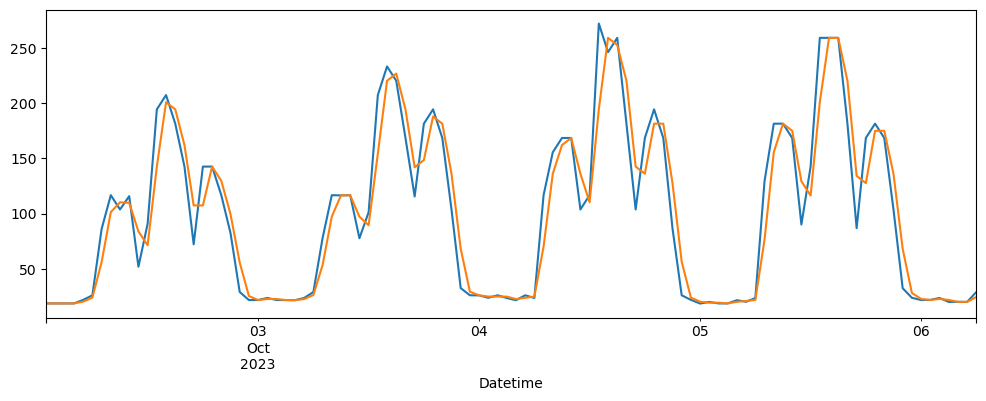

In [51]:
datos = df["Demanda"]
def media_movil(datos, ventana):
    return datos.rolling(window=ventana, min_periods=1).mean()

ventana = 2
resultado = media_movil(datos, ventana)
datos.plot()
resultado.plot()

Seguiremos trabajando con la serie original pero si queremos suavizar la gráfica ya sabemos que podemos aplicar las medias móviles como recurso.

In [52]:
modeloMA = ARIMA(train['Demanda'], order = (0,0,3)).fit()

In [53]:
predsMA = modeloMA.predict(start=len(train), end=len(df)-1)

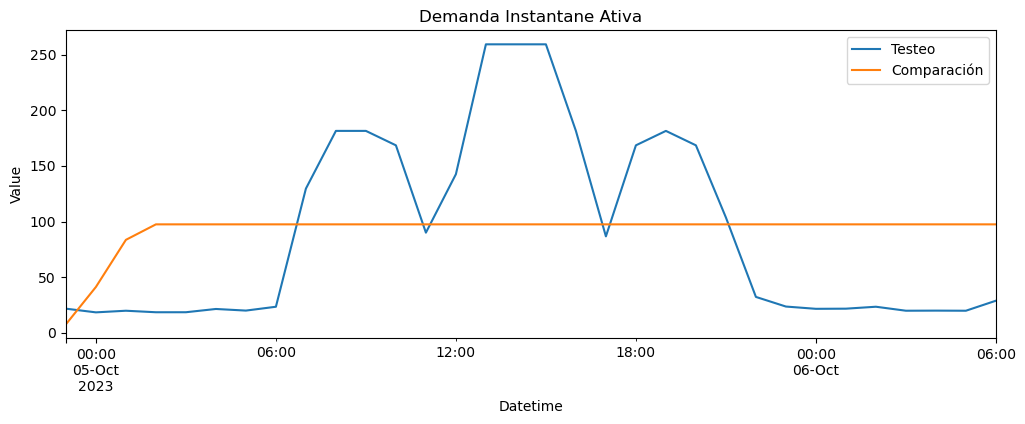

In [54]:
test["Demanda"].plot(label="Testeo")  # Gráfica
predsMA.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()

In [55]:
forecastMA=modeloMA.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

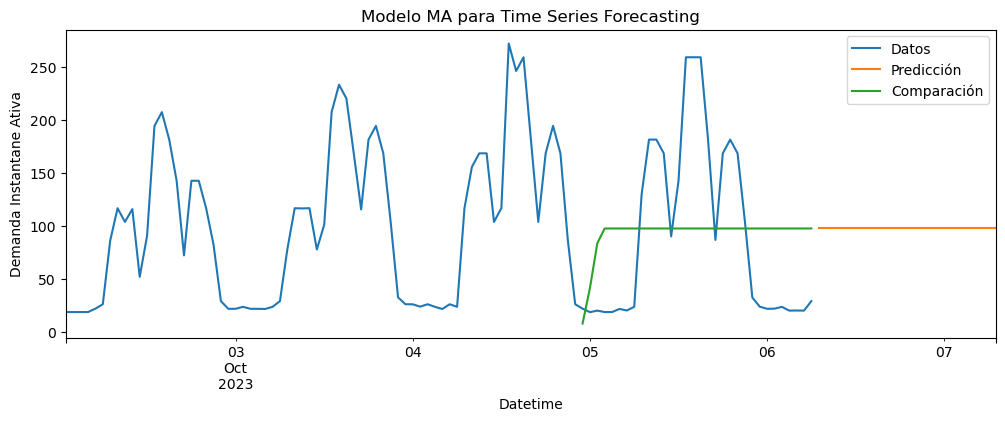

In [56]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastMA.plot(label="Predicción")
predsMA.plot(label="Comparación")
plt.title("Modelo MA para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

De esta forma no se obtuvo ningún resultado que se aproximara a los datos reales.

# Modelo ARMA

Un modelo ARMA (AutoRegressive Moving Average) es un modelo estadístico que combina tanto componentes autorregresivos (AR) como de media móvil (MA) para modelar una serie temporal. Estos modelos se utilizan para describir y predecir datos secuenciales, como series temporales financieras, datos económicos, datos climáticos y más. Aquí hay una breve explicación de los componentes AR y MA:

Modelo Autorregresivo (AR): Un modelo AR usa valores anteriores de la serie para predecir los valores futuros. Se basa en la idea de que los valores futuros de la serie están relacionados con los valores pasados.

Modelo de Media Móvil (MA): Un modelo MA utiliza términos de error pasados para predecir los valores futuros. Se basa en la idea de que los valores futuros de la serie están relacionados con los errores pasados.

Un modelo ARMA se denota como ARMA(p, q), donde "p" representa el orden del componente AR y "q" representa el orden del componente MA.

Como ya vimos en las gráficas de descomposición estacional y comprobamos con las pruebas, tenemos datos con características de estacionareidad por lo que no es necesario diferenciar la serie, en un modelo ARIMA es igual d=0.

### Según gráficas

In [57]:
if seleccion == "dataframe":
    p=2
    d=0
    q=3
else:
    p=3
    d=0
    q=3

In [58]:
modeloARMA0 = ARIMA(train['Demanda'], order = (p,d,q)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [59]:
predsARMA0 = modeloARMA0.predict(start = len(train), end = len(df)-1).rename("ARMA Predictions")

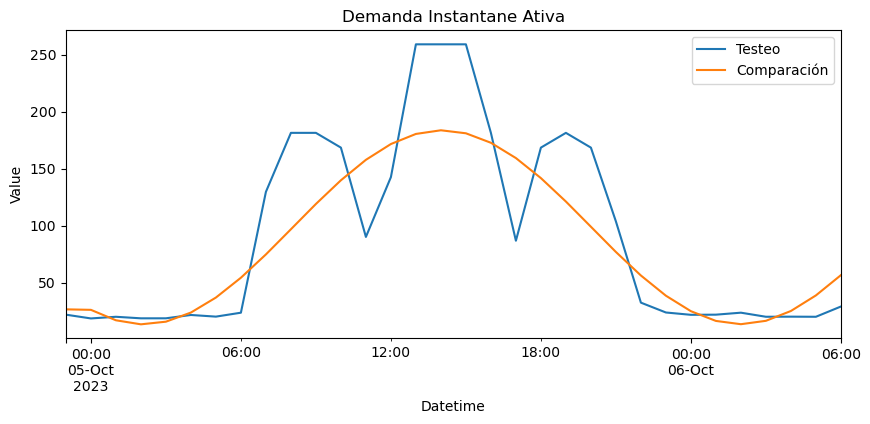

In [60]:
test['Demanda'].plot(figsize = (10,4), label="Testeo")
predsARMA0.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()

In [61]:
rmsARMA0 = np.sqrt(mean_squared_error(test["Demanda"], predsARMA0))  # Cálculo del RMSE
maeARMA0 = mean_absolute_error(test["Demanda"], predsARMA0)  # Cálculo del MAE

print(f'RMSE: {rmsARMA0}')
print(f'MAE: {maeARMA0}')

RMSE: 42.21431295959512
MAE: 31.562286650608392


In [62]:
forecastARMA0=modeloARMA0.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

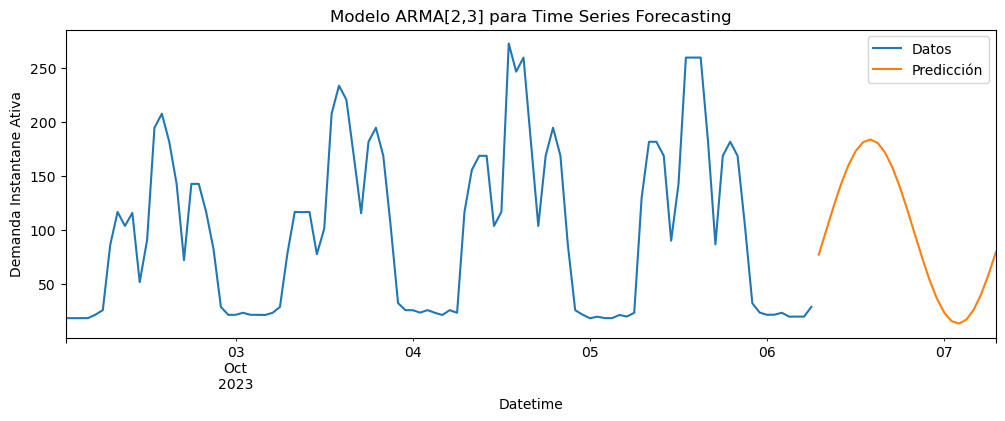

In [63]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastARMA0.plot(label="Predicción")
plt.title("Modelo ARMA[2,3] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [64]:
if seleccion == "dataframe":
    p=24
    d=0
    q=3
else:
    p=3
    d=0
    q=3

In [65]:
modeloARMA = ARIMA(train['Demanda'], order = (p,d,q)).fit()
modeloARMA.summary()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Demanda   No. Observations:                   70
Model:                ARIMA(24, 0, 3)   Log Likelihood                -295.266
Date:                Thu, 26 Oct 2023   AIC                            648.532
Time:                        15:34:20   BIC                            713.738
Sample:                    10-02-2023   HQIC                           674.432
                         - 10-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.0594     45.012      2.267      0.023      13.837     190.282
ar.L1         -0.0424      0.444     -0.096      0.924      -0.912       0.827
ar.L2          0.1545      0.495      0.312      0.755      -0.815       1.124
ar.L3          0.0831      0.491      0.169      0.866      -0.880       1.046
ar.L4          0.0249      0.325      0.077      0.939      -0.612       0.662
ar.L5          0.1473      0.290      0.507      0.612      -0.422       0.716
ar.L6          0.2613      0.323      0.810      0.418      -0.371       0.894
ar.L7         -0.2906      0.264     -1.099      0.272      -0.809       0.228
ar.L8         -0.2047      0.415     -0.493      0.622      -1.018       0.609
ar.L9          0.0343      0.291      0.118      0.906      -0.536       0.604
ar.L10         0.0343      0.428      0.080      0.936      -0.805       0.874
ar.L11        -0.2397      0.381     -0.628      0.530      -0.987       0.508
ar.L12         0.0428      0.220      0.194      0.846      -0.389       0.474
ar.L13         0.3179      0.292      1.088      0.276      -0.255       0.890
ar.L14        -0.1379      0.271     -0.509      0.611      -0.669       0.393
ar.L15        -0.1139      0.315     -0.361      0.718      -0.732       0.504
ar.L16         0.0546      0.356      0.153      0.878      -0.643       0.752
ar.L17         0.1071      0.326      0.328      0.743      -0.532       0.746
ar.L18        -0.1574      0.256     -0.614      0.539      -0.660       0.345
ar.L19         0.1729      0.220      0.788      0.431      -0.257       0.603
ar.L20         0.0478      0.275      0.174      0.862      -0.491       0.586
ar.L21         0.0351      0.345      0.102      0.919      -0.641       0.711
ar.L22        -0.1856      0.287     -0.646      0.519      -0.749       0.378
ar.L23         0.0439      0.246      0.179      0.858      -0.437       0.525
ar.L24         0.6491      0.261      2.491      0.013       0.138       1.160
ma.L1          0.7089      0.599      1.183      0.237      -0.466       1.883
ma.L2          0.6861      0.622      1.104      0.270      -0.532       1.904
ma.L3          0.4844      0.731      0.662      0.508      -0.949       1.918
sigma2       204.8492     64.231      3.189      0.001      78.958     330.740
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                52.30
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.95
Prob(H) (two-sided):                  0.48   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
predsARMA = modeloARMA.predict(start = len(train), end = len(df)-1).rename("ARMA Predictions")

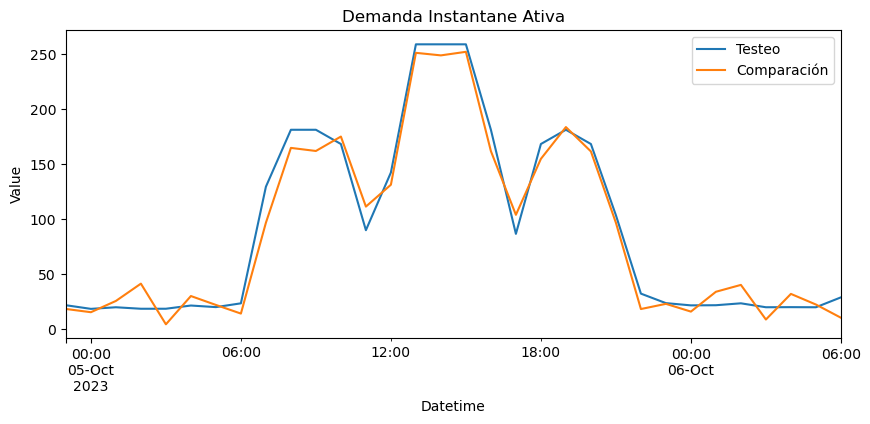

In [67]:
test['Demanda'].plot(figsize = (10,4), label="Testeo")
predsARMA.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotComARMA.png")

In [68]:
rmsARMA = np.sqrt(mean_squared_error(test["Demanda"], predsARMA))  # Cálculo del RMSE
maeARMA = mean_absolute_error(test["Demanda"], predsARMA)  # Cálculo del MAE

print(f'RMSE: {rmsARMA}')
print(f'MAE: {maeARMA}')

RMSE: 13.393707905001177
MAE: 11.30502416561822


In [69]:
forecastARMA=modeloARMA.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

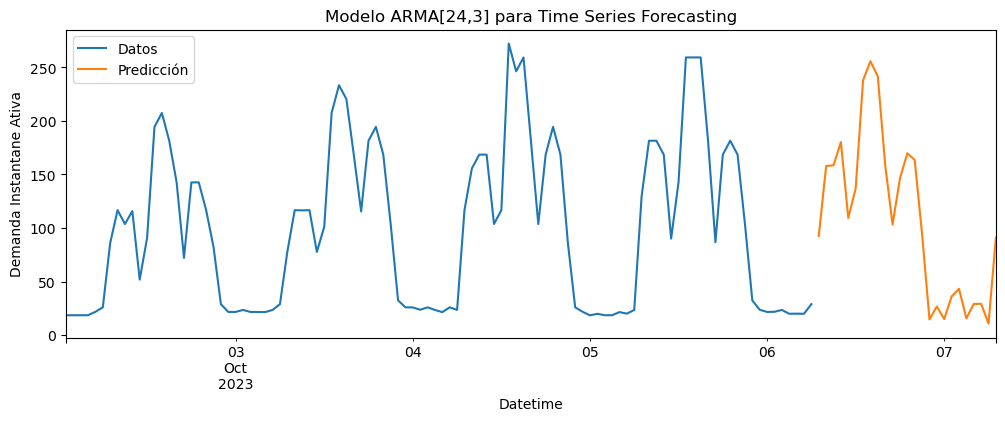

In [70]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastARMA.plot(label="Predicción")
plt.title("Modelo ARMA[24,3] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForARMA.png")

## Diagnosis

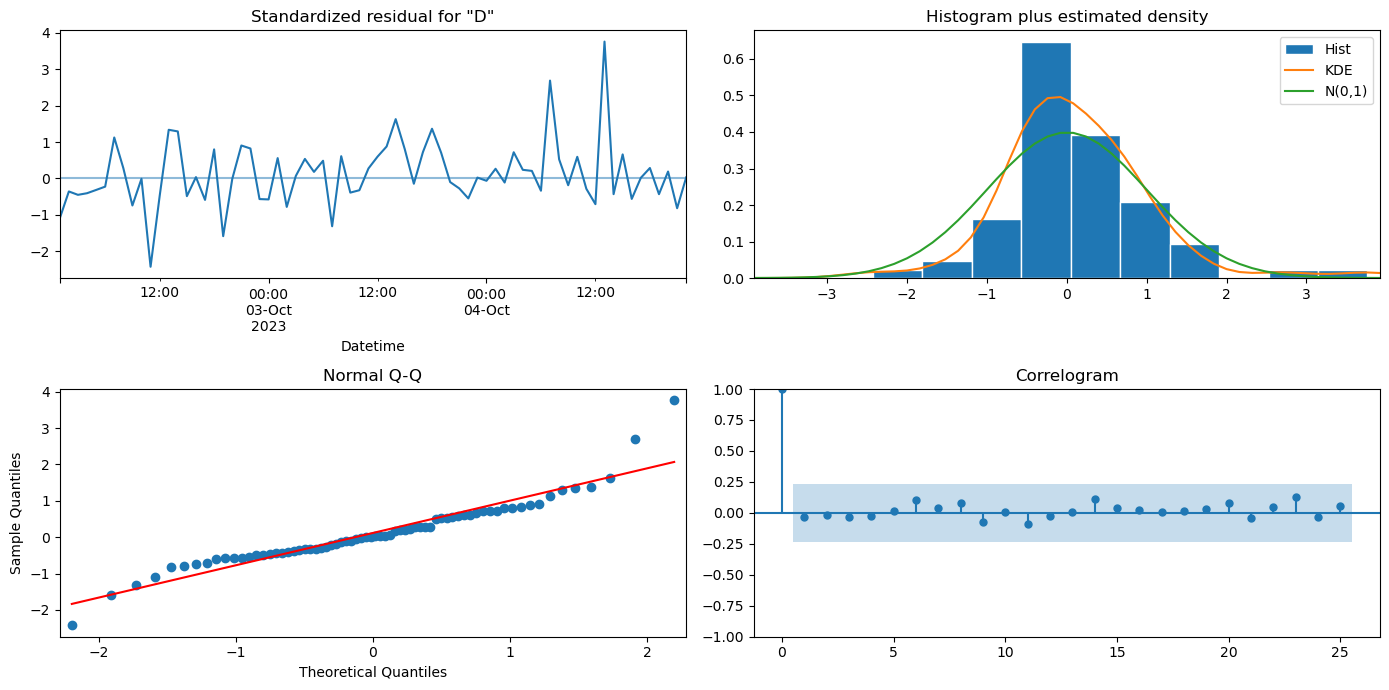

In [71]:
modeloARMA.plot_diagnostics(lags=25, figsize=(14, 7))
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsARMA.png")
plt.tight_layout()
plt.show()

## Creación del Gauge Chart 2

### Datos 2

In [72]:
valor_predito = forecastARMA[0]  # Se toma el primer dato de predicción futura

In [73]:
title = "ARMA["+str(24)+','+str(3)+"](Demanda Instantânea Ativa)"
figura = crear_figura_gauge(last_number, meta)
figura.show()
figura.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeARMA.png")

In [74]:
figura_tendencia = crear_figura_tendencia(valor_predito, last_number)
figura_tendencia.show()
figura_tendencia.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigARMA.png")

# Modelo ARIMA
Los modelos ARIMA son acrónimo de su definición en inglés autoregressive (AR) integrated (I) moving average (MA), que significa modelo autorregresivo integrado de media móvil.

El modelo ARIMA genera una serie temporal a partir de 3 parámetros llamados órdenes del modelo ARIMA(p,d,q). Como indica el acrónimo se trata de 3 modelos distintos unidos: AR + I + MA. Los ARIMA son la forma generalizada de los modelos ARMA(p,q) que sirven para descomponer, analizar o pronosticar series temporales estacionarias.

El parámetro d indica el orden de diferenciación de la serie para que sea estacionaria. Para encontrar el parámetro p y q, podemos ver las características de sus gráficas de autocorrelación y autocorrelación parcial. Se puede aplicar también un módulo auto_ARIMA que con una serie de combinaciones elige los mejores parámetros para que el modelo sea entrenado.

Aquí tenemos en cuenta los datos diferenciados en donde se prueba primero con los primeros valores que cruzan la línea de significancia ((6,1,5) para horario y (3,1,1) para las muestras cada minuto). Aquí se mira el ACF para el valor p y el PACF para hallar el valor q por la forma de los datos. Si se desea mirar el valor con más significancia en cada gráfico se ve que es (24,1,11).

### Según Gráficas

In [75]:
if seleccion == "dataframe":
    p=6
    d=1
    q=5
    
else:
    p=4 #3
    d=1 #1
    q=2 #1

In [76]:
modeloARIMA0 = ARIMA(train['Demanda'], order = (p,d,q)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [77]:
predsARIMA0 = modeloARIMA0.predict(start = len(train), end = len(df)-1).rename("ARIMA Predictions")

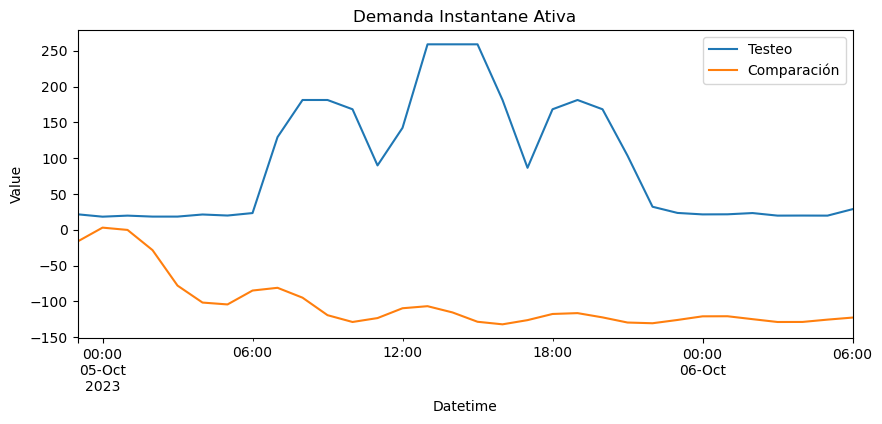

In [78]:
test['Demanda'].plot(figsize = (10,4), label="Testeo")
predsARIMA0.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()

In [79]:
rmsARIMA0 = np.sqrt(mean_squared_error(test["Demanda"], predsARIMA0))  # Cálculo del RMSE
maeARIMA0 = mean_absolute_error(test["Demanda"], predsARIMA0)  # Cálculo del MAE

print(f'RMSE: {rmsARIMA0}')
print(f'MAE: {maeARIMA0}')

RMSE: 219.41411313273449
MAE: 194.44316969971635


In [80]:
forecastARIMA0=modeloARIMA0.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

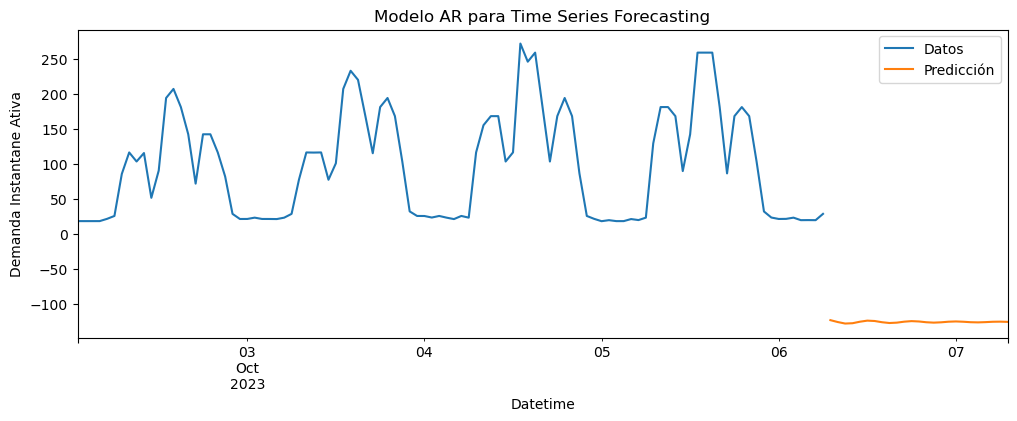

In [81]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastARIMA0.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [82]:
if seleccion == "dataframe":
    p=24
    d=1
    q=11
else:
    p=4
    d=1
    q=2

In [83]:
modeloARIMA = ARIMA(train['Demanda'], order = (p,d,q)).fit()
modeloARIMA.summary()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Demanda   No. Observations:                   70
Model:               ARIMA(24, 1, 11)   Log Likelihood                -290.910
Date:                Thu, 26 Oct 2023   AIC                            653.820
Time:                        15:34:26   BIC                            734.248
Sample:                    10-02-2023   HQIC                           685.729
                         - 10-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0347      0.267      0.130      0.897      -0.488       0.558
ar.L2          0.1186      0.270      0.439      0.661      -0.411       0.648
ar.L3         -0.0461      0.271     -0.170      0.865      -0.577       0.485
ar.L4          0.0111      0.219      0.051      0.960      -0.418       0.440
ar.L5         -0.0374      0.182     -0.205      0.837      -0.395       0.320
ar.L6          0.1628      0.264      0.617      0.537      -0.354       0.680
ar.L7         -0.1757      0.197     -0.892      0.372      -0.562       0.210
ar.L8         -0.1453      0.238     -0.610      0.542      -0.612       0.321
ar.L9          0.1359      0.286      0.475      0.635      -0.425       0.697
ar.L10         0.1200      0.297      0.404      0.686      -0.461       0.701
ar.L11        -0.3005      0.249     -1.205      0.228      -0.789       0.188
ar.L12         0.0289      0.225      0.129      0.898      -0.412       0.469
ar.L13         0.2969      0.237      1.253      0.210      -0.168       0.761
ar.L14        -0.2195      0.223     -0.984      0.325      -0.657       0.218
ar.L15        -0.0942      0.227     -0.415      0.678      -0.539       0.351
ar.L16         0.1313      0.228      0.577      0.564      -0.315       0.578
ar.L17         0.1339      0.281      0.476      0.634      -0.417       0.685
ar.L18        -0.2189      0.202     -1.082      0.279      -0.615       0.177
ar.L19         0.1825      0.261      0.699      0.485      -0.329       0.694
ar.L20        -0.0902      0.335     -0.270      0.788      -0.746       0.566
ar.L21         0.0731      0.252      0.290      0.772      -0.421       0.567
ar.L22        -0.1663      0.239     -0.695      0.487      -0.635       0.303
ar.L23         0.0524      0.275      0.191      0.849      -0.486       0.591
ar.L24         0.8754      0.292      2.997      0.003       0.303       1.448
ma.L1         -0.3882      2.795     -0.139      0.890      -5.867       5.090
ma.L2          0.0040      3.662      0.001      0.999      -7.174       7.182
ma.L3         -0.0490      4.494     -0.011      0.991      -8.857       8.759
ma.L4         -0.5866      2.365     -0.248      0.804      -5.222       4.049
ma.L5          0.4193      4.307      0.097      0.922      -8.022       8.861
ma.L6          0.5311      3.485      0.152      0.879      -6.298       7.361
ma.L7         -0.7200      3.346     -0.215      0.830      -7.278       5.838
ma.L8          0.1454      5.345      0.027      0.978     -10.331      10.622
ma.L9         -0.4477      4.424     -0.101      0.919      -9.119       8.224
ma.L10        -0.3855      4.068     -0.095      0.925      -8.359       7.588
ma.L11         0.6021      3.992      0.151      0.880      -7.221       8.426
sigma2        58.4723    355.950      0.164      0.870    -639.177     756.121
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              

In [84]:
predsARIMA = modeloARIMA.predict(start = len(train), end = len(df)-1).rename("ARIMA Predictions")

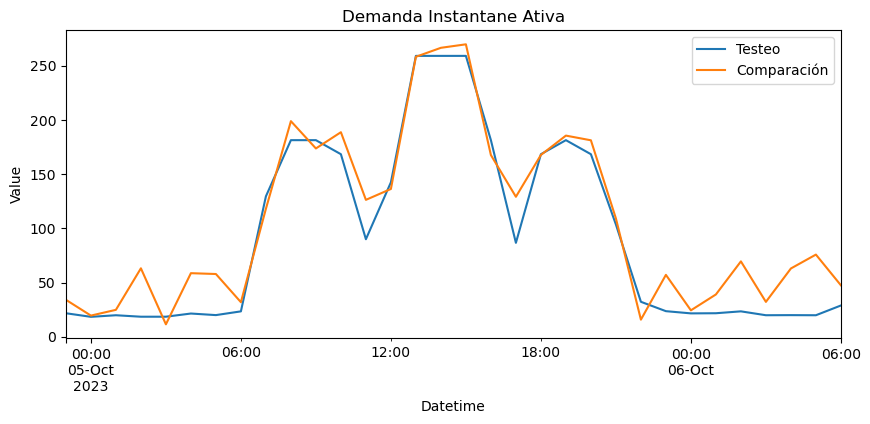

In [85]:
test['Demanda'].plot(figsize = (10,4), label="Testeo")
predsARIMA.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotComARIMA0.png")

In [86]:
rmsARIMA = np.sqrt(mean_squared_error(test["Demanda"], predsARIMA))  # Cálculo del RMSE
maeARIMA = mean_absolute_error(test["Demanda"], predsARIMA)  # Cálculo del MAE

print(f'RMSE: {rmsARIMA}')
print(f'MAE: {maeARIMA}')

RMSE: 24.416130430111114
MAE: 18.68557983917813


In [87]:
forecastARIMA=modeloARIMA.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

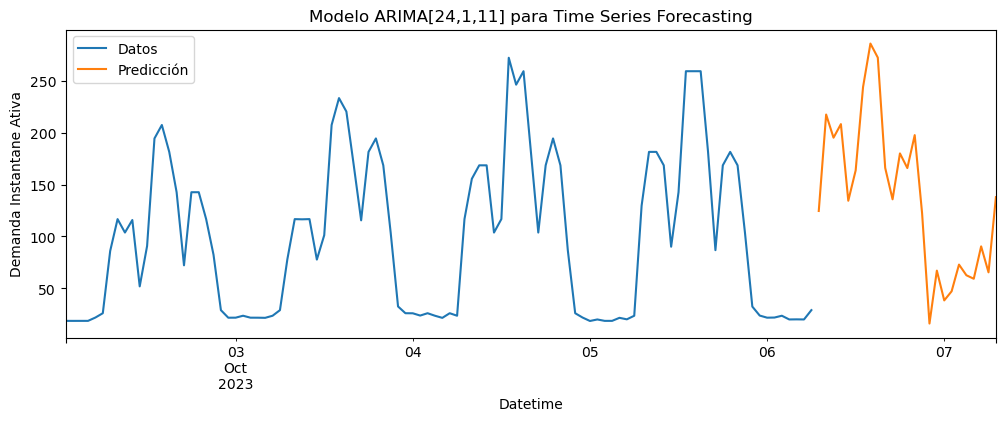

In [88]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastARIMA.plot(label="Predicción")
plt.title("Modelo ARIMA[24,1,11] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForARIMA.png")

## Diagnosis

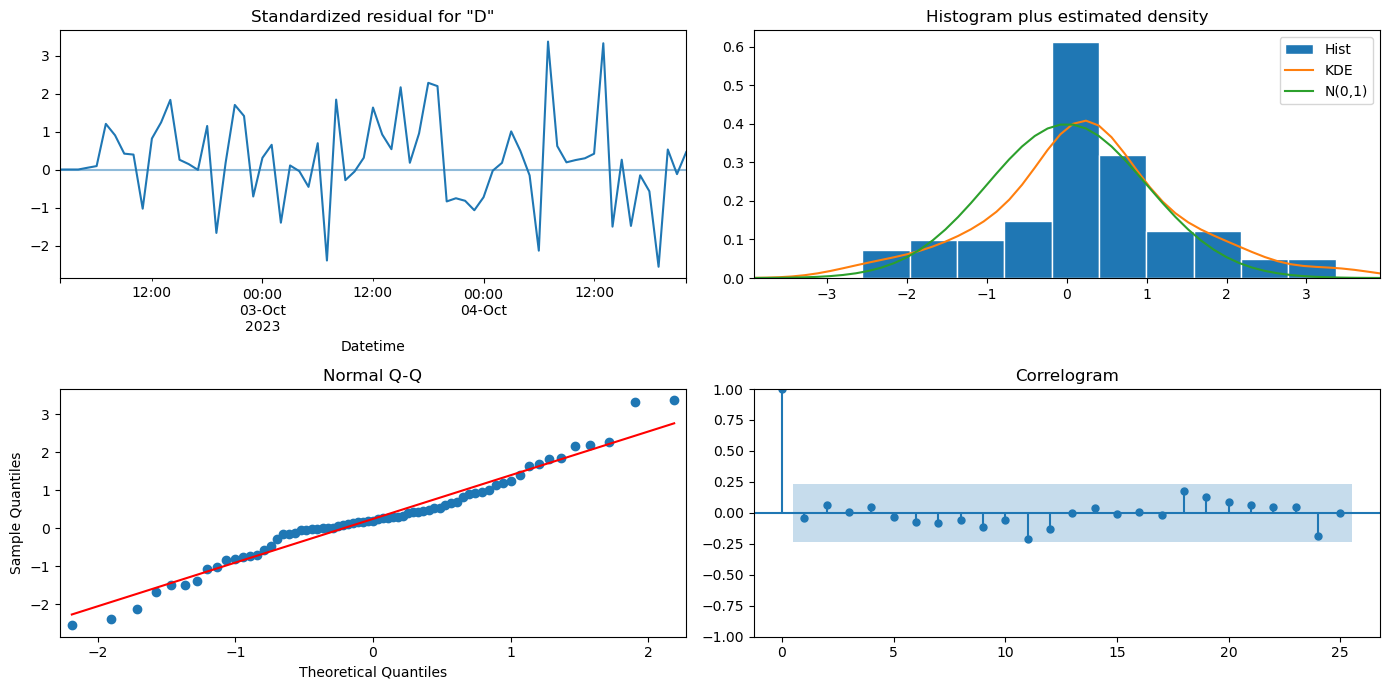

In [89]:
modeloARIMA.plot_diagnostics(lags=25, figsize=(14, 7))
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsARIMA.png")
plt.tight_layout()
plt.show()

## Creación del Gauge Chart 3

### Datos 3

In [90]:
valor_predito = forecastARIMA[0]  # Se toma el primer dato de predicción futura

In [91]:
title = "ARIMA["+str(24)+','+str(1)+','+str(11)+"](Demanda Instantânea Ativa)"
figura = crear_figura_gauge(last_number, meta)
figura.show()
figura.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeARIMA0.png")

In [92]:
figura_tendencia = crear_figura_tendencia(valor_predito, last_number)
figura_tendencia.show()
figura_tendencia.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigARIMA.png")

### Variar los parámetros de p, d y q para encontrar el mejor modelo
Se realiza una función que realiza diferentes combinaciones entre sus parámetros y luego los va a ordenar desde la mejor según AIC o BIC encontrada.

In [93]:
# order_aic_bic = []

# for p in range(26):
#     for d in range(2):  
#         for q in range(7):  
#             try:
#                 modeloVarARIMA = ARIMA(train["Demanda"], order=(p, d, q))   # Create and fit SARIMAX model
#                 resultsVarARIMA = modeloVarARIMA.fit()  # Increase maxiter as needed

#                 order_aic_bic.append((p, d, q, resultsVarARIMA.aic, resultsVarARIMA.bic))  # Append order and results tuple
#             except Exception as e:
#                 print(f"Error for order ({p},{d},{q}): {str(e)}")

# sorted_results = sorted(order_aic_bic, key=lambda x: x[3])  # Sort by BIC Sort the results by AIC or BIC (choose one)

# for order in sorted_results:  # Print the sorted results
#     print(f"Order (p,d,q): ({order[0]},{order[1]},{order[2]}) - AIC: {order[3]}, BIC: {order[4]}")

In [94]:
# order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q','AIC','BIC'])  # Construct DataFrame from order_aic_bic

Para ordenadar por AIC o por BIC se realizaron dos cálculos que arrojaron las mejores combinaciones que prueba p, d y q desde 0 hasta p=30, d=0, q=7. Es decir, tomando los datos de la serie original.
Por otro lado, también se ordenó por AIC y BIC para las mejores combinaciones con los mismos valores de p y q pero hasta d=1. Serie diferenciada. Tener cuidado porque se puede obtener "mejores" resultados de AIC y BIC con series más diferenciadas, que en realidad están sobre diferenciadas y presentan problemas en sus modelos de predicción.

#### Ordenar por AIC

In [95]:
# order_df.sort_values('AIC')  # Print order_df in order of increasing AIC

- Según la variación de parámetros según el AIC y combinar hasta p=30, q=7 y d=0 (para la serie original) podemos ordenar la mejor combinación con (25,0,0), (24,0,3), (24/25,0,4) con un AIC de 646.26, 648.53 y 649.87 respectivamente.

- Según la variación de parámetros según el AIC y combinar hasta p=30, q=7 y d=1 (para la serie diferenciada) podemos ordenar la mejor combinación con (24,1,0), (24,1,1), (25,1,0) con un AIC de 633.59, 634.67 y 636.17 respectivamente.

#### Ordenar por BIC

In [96]:
# order_df.sort_values('BIC')  # Print order_df in order of increasing BIC

- Según la variación de parámetros según el BIC y combinar hasta p=30, q=7 y d=0 (para la serie original) podemos ordenar la mejor combinación con (10,0,2), (12,0,2), (24,0,3) con un BIC de 665.85, 663.28 y 713.73 respectivamente.

- Según la variación de parámetros según el BIC y combinar hasta p=30, q=7 y d=1 (para la serie diferenciada) podemos ordenar la mejor combinación (11,1,2), (15,1,1), (24,1,0) con un BIC de 688.51, 688.77 y 689.44 respectivamente.

### Se realiza prueba con los dos primeros de cada uno

Vemos que en ambos podios se encuentran (24,0,3) y (24,1,0). Seleccionamos las dos primeras combinaciones según BIC y dos según AIC para las combinaciones con d=0 y otras con d=1. Por lo tanto:

- Para las combinaciones ARMA con d=0, se seleccionan (25,0,0) y (24,0,3) según AIC y (10,0,2) y (12,0,2) según BIC. Como ya se probó en un análisis anterior la combinación (24,0,3) se probarán (25,0,0), (10,0,2) y (12,0,2). 

- Para las combinaciones ARIMA con d=1, se seleccionan (24,1,0) y (24,1,1) según AIC y (11,1,2) y (15,1,1) según BIC.

##### Para d=0

In [97]:
modeloVarARIMA1 = sm.tsa.ARIMA(train["Demanda"], order=(25, 0, 0)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<Axes: xlabel='Datetime'>

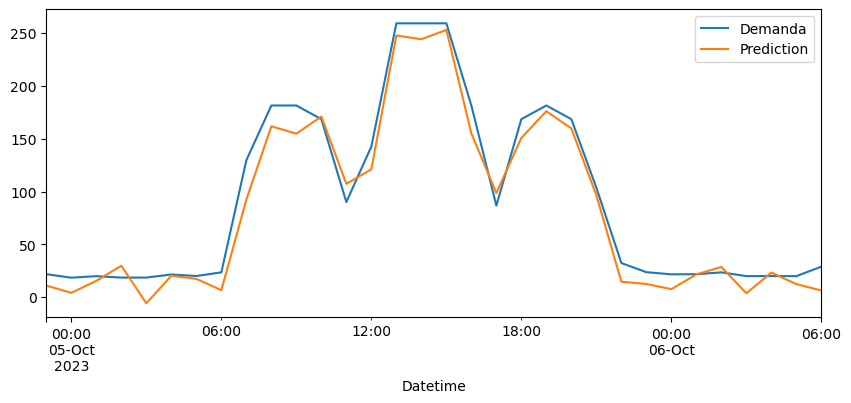

In [98]:
predsVarARIMA1 = modeloVarARIMA1.predict(start = len(train), end = len(df)-1).rename("Prediction")
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA1.plot(legend = True)

In [99]:
rmseVarARIMA1 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA1))  # Cálculo del RMSE
maeVarARIMA1 = mean_absolute_error(test["Demanda"], predsVarARIMA1)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA1}')
print(f'MAE: {maeVarARIMA1}')

RMSE: 15.625662428052609
MAE: 13.075701539089685


In [100]:
forecastVarARIMA1=modeloVarARIMA1.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

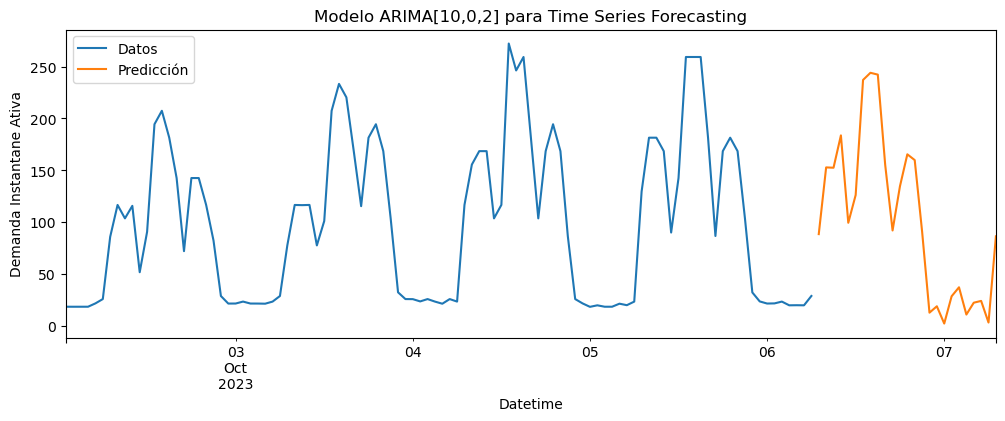

In [101]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA1.plot(label="Predicción")
plt.title("Modelo ARIMA[10,0,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [102]:
modeloVarARIMA2 = sm.tsa.ARIMA(train["Demanda"], order=(10, 0, 2)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [103]:
predsVarARIMA2 = modeloVarARIMA2.predict(start = len(train), end = len(df)-1).rename("Prediction")

<Axes: xlabel='Datetime'>

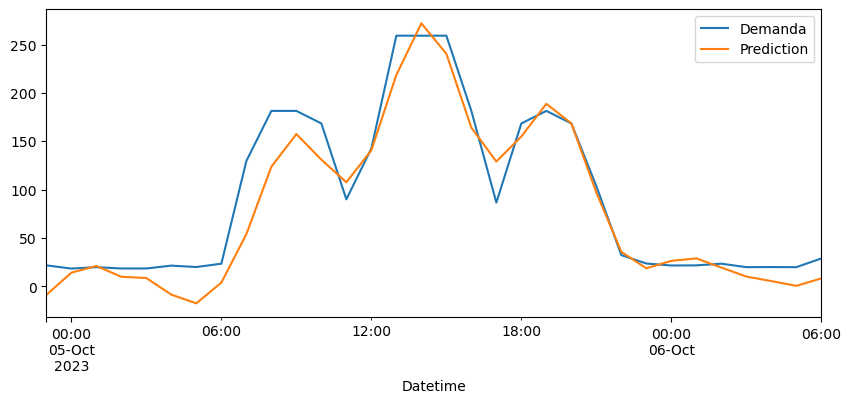

In [104]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA2.plot(legend = True)

In [105]:
rmseVarARIMA2 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA2))  # Cálculo del RMSE
maeVarARIMA2 = mean_absolute_error(test["Demanda"], predsVarARIMA2)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA2}')
print(f'MAE: {maeVarARIMA2}')

RMSE: 25.569676768158647
MAE: 18.85477717575348


In [106]:
forecastVarARIMA2=modeloVarARIMA2.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

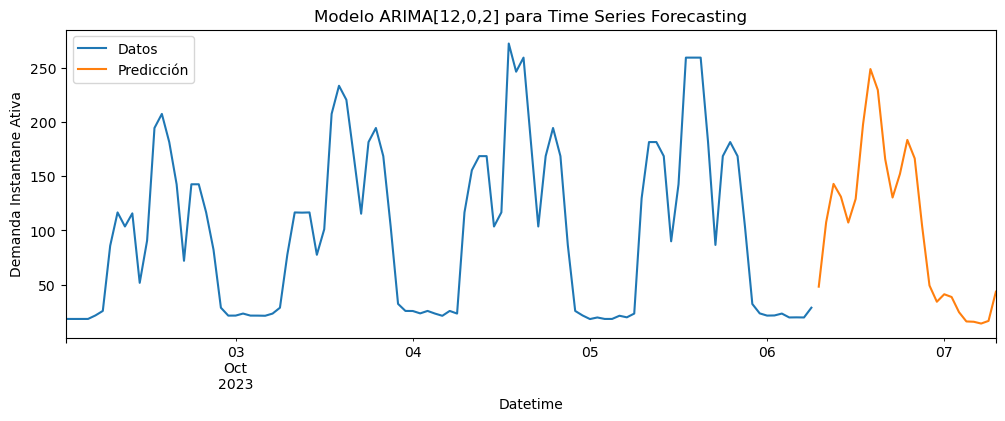

In [107]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA2.plot(label="Predicción")
plt.title("Modelo ARIMA[12,0,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [108]:
modeloVarARIMA3 = sm.tsa.ARIMA(train["Demanda"], order=(12, 0, 2)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [109]:
predsVarARIMA3 = modeloVarARIMA3.predict(start = len(train), end = len(df)-1).rename("Prediction")

<Axes: xlabel='Datetime'>

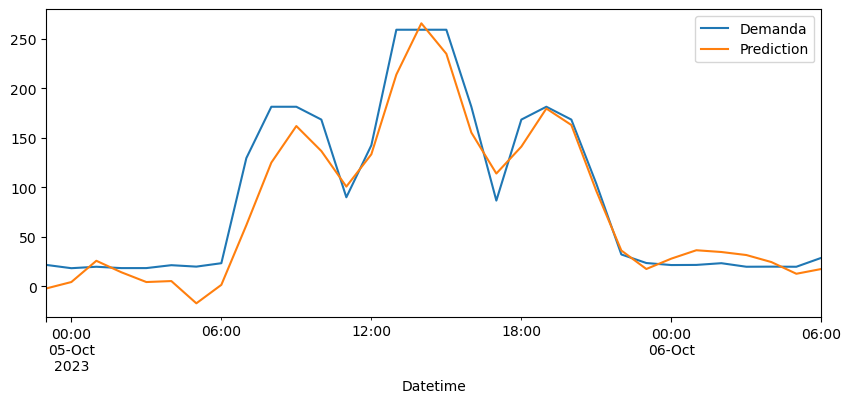

In [110]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA3.plot(legend = True)

In [111]:
rmseVarARIMA3 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA3))  # Cálculo del RMSE
maeVarARIMA3 = mean_absolute_error(test["Demanda"], predsVarARIMA3)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA3}')
print(f'MAE: {maeVarARIMA3}')

RMSE: 23.83872454273432
MAE: 18.151199533408075


In [112]:
forecastVarARIMA3=modeloVarARIMA3.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

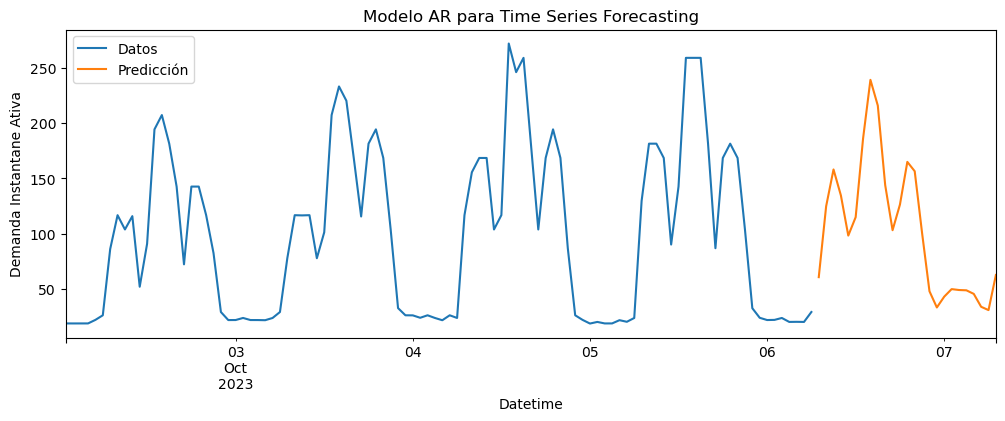

In [113]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA3.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

##### Para d=1

In [114]:
modeloVarARIMA4 = sm.tsa.ARIMA(train["Demanda"], order=(24, 1, 0)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [115]:
predsVarARIMA4 = modeloVarARIMA4.predict(start = len(train), end = len(df)-1).rename("Prediction")

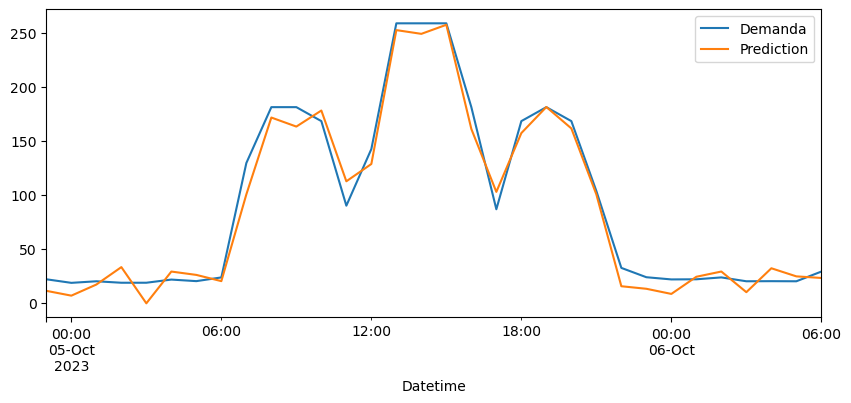

In [116]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA4.plot(legend = True)
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotComVarARIMA4.png")

In [117]:
rmseVarARIMA4 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA4))  # Cálculo del RMSE
maeVarARIMA4 = mean_absolute_error(test["Demanda"], predsVarARIMA4)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA4}')
print(f'MAE: {maeVarARIMA4}')

RMSE: 12.390236621157403
MAE: 10.481950952532374


In [118]:
forecastVarARIMA4=modeloVarARIMA4.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

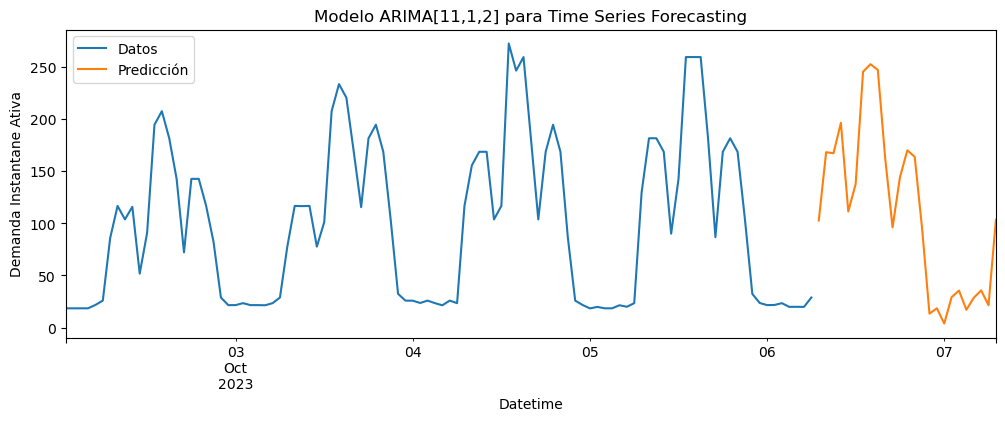

In [119]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA4.plot(label="Predicción")
plt.title("Modelo ARIMA[11,1,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForVarARIMA4.png")

In [120]:
modeloVarARIMA5 = sm.tsa.ARIMA(train["Demanda"], order=(24, 1, 1)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [121]:
predsVarARIMA5 = modeloVarARIMA5.predict(start = len(train), end = len(df)-1).rename("Prediction")

<Axes: xlabel='Datetime'>

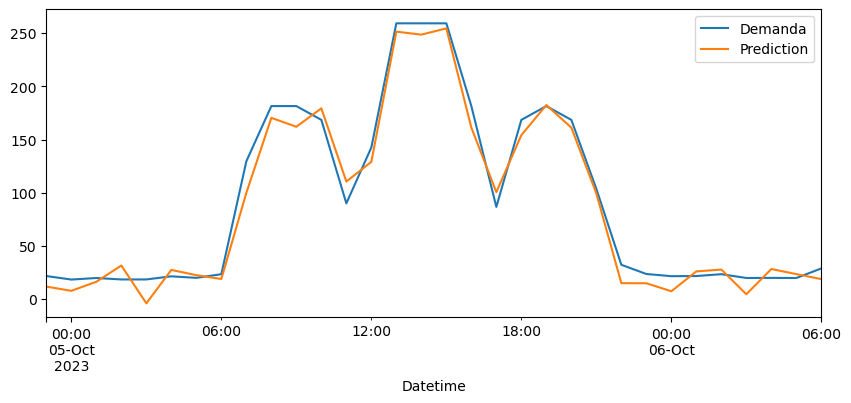

In [122]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA5.plot(legend = True)

In [123]:
rmseVarARIMA5 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA5))  # Cálculo del RMSE
maeVarARIMA5 = mean_absolute_error(test["Demanda"], predsVarARIMA5)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA5}')
print(f'MAE: {maeVarARIMA5}')

RMSE: 12.705262029285086
MAE: 10.873908803598948


In [124]:
forecastVarARIMA5=modeloVarARIMA5.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

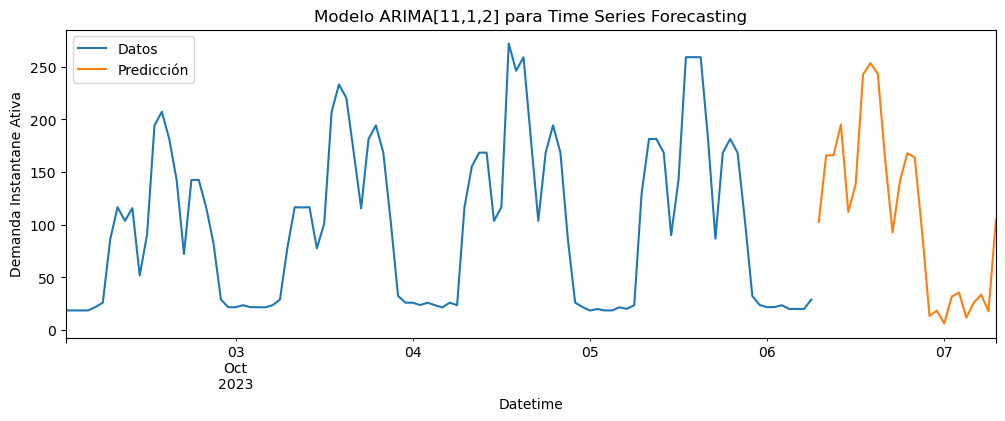

In [125]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA5.plot(label="Predicción")
plt.title("Modelo ARIMA[11,1,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [126]:
modeloVarARIMA6 = sm.tsa.ARIMA(train["Demanda"], order=(11, 1, 2)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [127]:
predsVarARIMA6 = modeloVarARIMA6.predict(start = len(train), end = len(df)-1).rename("Prediction")

<Axes: xlabel='Datetime'>

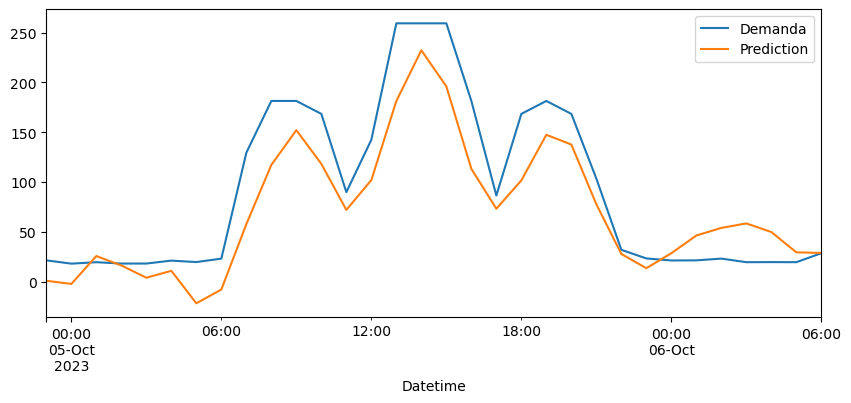

In [128]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA6.plot(legend = True)

In [129]:
rmseVarARIMA6 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA6))  # Cálculo del RMSE
maeVarARIMA6 = mean_absolute_error(test["Demanda"], predsVarARIMA6)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA6}')
print(f'MAE: {maeVarARIMA6}')

RMSE: 37.66283934583792
MAE: 30.64890637786607


In [130]:
forecastVarARIMA6 = modeloVarARIMA6.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

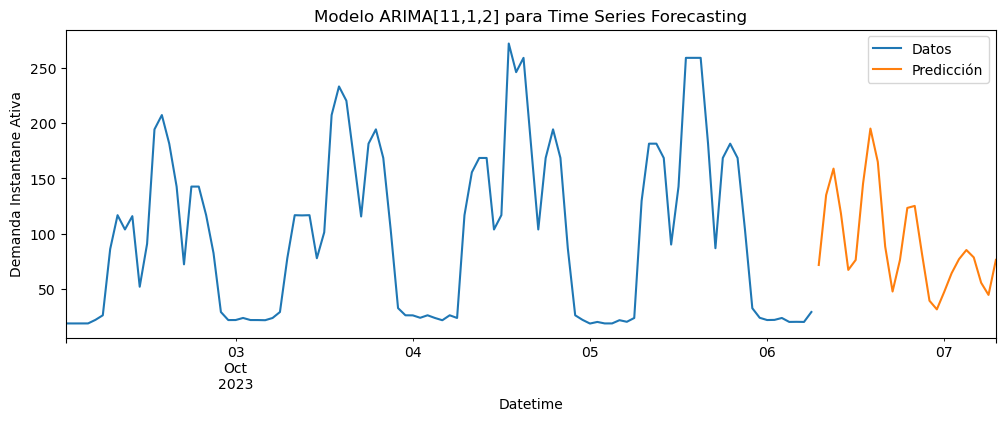

In [131]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA6.plot(label="Predicción")
plt.title("Modelo ARIMA[11,1,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [132]:
modeloVarARIMA7 = sm.tsa.ARIMA(train["Demanda"], order=(15, 1, 1)).fit()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [133]:
predsVarARIMA7 = modeloVarARIMA7.predict(start = len(train), end = len(df)-1).rename("Prediction")

<Axes: xlabel='Datetime'>

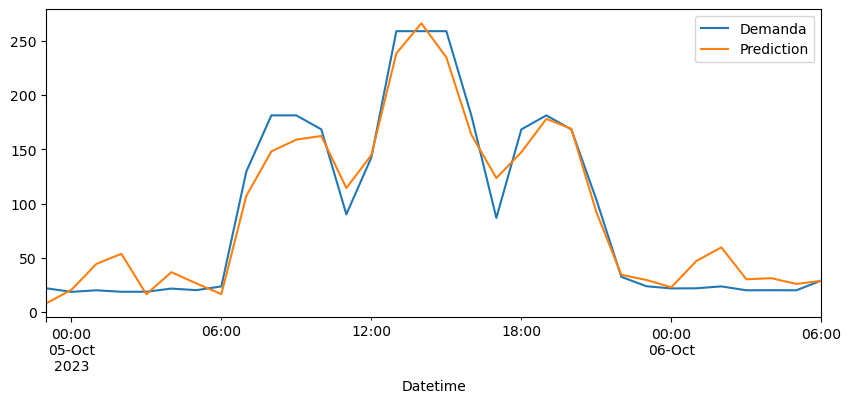

In [134]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA7.plot(legend = True)

In [135]:
rmseVarARIMA7 = np.sqrt(mean_squared_error(test["Demanda"], predsVarARIMA7))  # Cálculo del RMSE
maeVarARIMA7 = mean_absolute_error(test["Demanda"], predsVarARIMA7)  # Cálculo del MAE

print(f'RMSE: {rmseVarARIMA7}')
print(f'MAE: {maeVarARIMA7}')

RMSE: 18.23315748985765
MAE: 14.27964813642363


In [136]:
forecastVarARIMA7 = modeloVarARIMA7.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

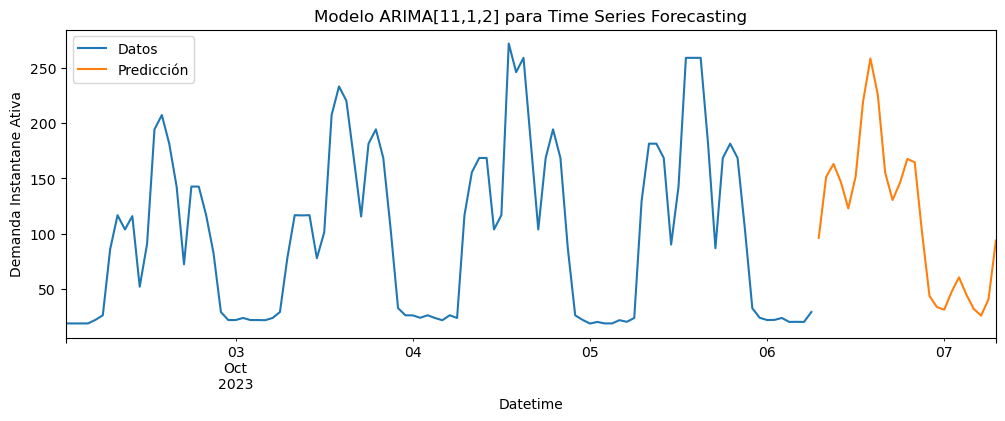

In [137]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastVarARIMA7.plot(label="Predicción")
plt.title("Modelo ARIMA[11,1,2] para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

Se evaluaron 4 combinaciones para d=0 y 4 combinaciones para d=1. Como en un análisis anterior se propuso y se probó una combinación con d=0 (24,0,3) a partir de las gráficas ACF y PACF, quedaron restando 7 de las cuales se organizaron según el error presentado en las pruebas. 

### Tabla resumen de variación de parámetros

Se presenta una tabla resumen que presenta los resultados obtenidos según AIC y BIC, y se ordenaron de acuerdo al error RSME y MAE.

In [138]:
modelos = [modeloVarARIMA1, modeloVarARIMA2, modeloVarARIMA3, modeloVarARIMA4, modeloVarARIMA5, modeloVarARIMA6, modeloVarARIMA7]

parametros = []  # Crear una lista de valores de los parámetros para cada modelo
for modelo in modelos:
    ar_order = modelo.model_orders["ar"]
    ma_order = modelo.model_orders["ma"]
    exog_variable = modelo.model_orders["exog"]
    exog_invertida = 1 - exog_variable
    parametros_texto = f'p={ar_order}, d={exog_invertida}, q={ma_order}'
    parametros.append(parametros_texto)

df_resultados = pd.DataFrame({'Modelo': [f'modeloVarARIMA{i+1}' for i in range(len(modelos))],  # Crear el DataFrame con modelos, métricas y la columna "Parámetros"
                              'Parámetros': parametros,
                              'AIC': [modelo.aic for modelo in modelos],
                              'BIC': [modelo.bic for modelo in modelos],
                              'RMSE': [rmseVarARIMA1, rmseVarARIMA2, rmseVarARIMA3, rmseVarARIMA4, rmseVarARIMA5, rmseVarARIMA6, rmseVarARIMA7],
                              'MAE': [maeVarARIMA1, maeVarARIMA2, maeVarARIMA3, maeVarARIMA4, maeVarARIMA5, maeVarARIMA6, maeVarARIMA7]
                              })

nueva_fila = pd.DataFrame({
    'Modelo': 'modeloARMA',
    'AIC': [modeloARMA.aic],
    'BIC': [modeloARMA.bic],
    'RMSE': [rmsARMA],
    'MAE': [maeARMA],
    'Parámetros': 'p=24, q=3'
})

df_resultados = pd.concat([df_resultados, nueva_fila], ignore_index=True)  # Concatenar el DataFrame original con el nuevo DataFrame para agregar la nueva fila

df_ordenado = df_resultados.sort_values(by='RMSE').round(2)  # Ordenar el DataFrame por el valor de RMSE en orden ascendente (menor a mayor) y redondear los valores

df_ordenado  # Imprimir el DataFrame ordenado

Modelo      Parámetros     AIC     BIC   RMSE    MAE
3  modeloVarARIMA4  p=24, d=1, q=0  633.59  689.45  12.39  10.48
4  modeloVarARIMA5  p=24, d=1, q=1  634.68  692.76  12.71  10.87
7       modeloARMA       p=24, q=3  648.53  713.74  13.39  11.31
0  modeloVarARIMA1  p=25, d=0, q=0  646.26  706.97  15.63  13.08
6  modeloVarARIMA7  p=15, d=1, q=1  650.80  688.78  18.23  14.28
2  modeloVarARIMA3  p=12, d=0, q=2  663.29  699.26  23.84  18.15
1  modeloVarARIMA2  p=10, d=0, q=2  665.85  697.33  25.57  18.85
5  modeloVarARIMA6  p=11, d=1, q=2  657.24  688.52  37.66  30.65

### Mejores

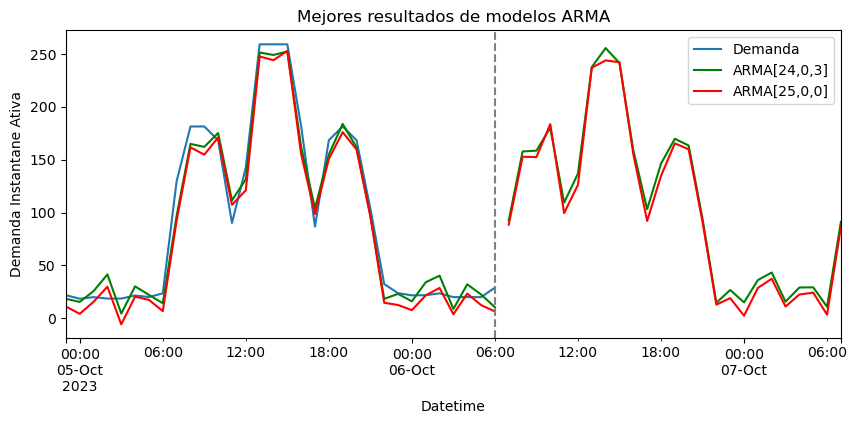

In [139]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsARMA.plot(label="ARMA[24,0,3]", color="g", legend=True)
forecastARMA.plot(color="g")
predsVarARIMA1.plot(label="ARMA[25,0,0]", color="r", legend=True)
forecastVarARIMA1.plot(color="r")

plt.axvline(x='2023-10-06 06:00:00', color='gray', linestyle='--', label='División Test/Predicción')
plt.title("Mejores resultados de modelos ARMA")
plt.ylabel("Demanda Instantane Ativa")
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForMejARMA.png")

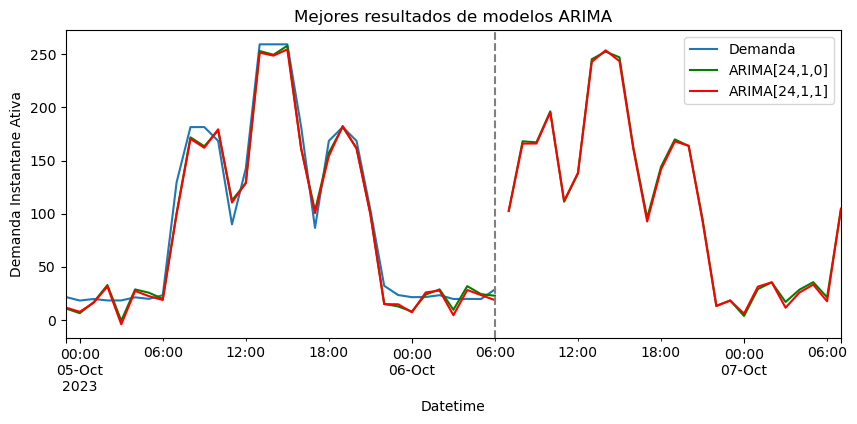

In [140]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA4.plot(label="ARIMA[24,1,0]", color="g", legend=True)
forecastVarARIMA4.plot(color="g")
predsVarARIMA5.plot(label="ARIMA[24,1,1]", color="r", legend=True)
forecastVarARIMA5.plot(color="r")

plt.axvline(x='2023-10-06 06:00:00', color='gray', linestyle='--', label='División Test/Predicción')
plt.title("Mejores resultados de modelos ARIMA")
plt.ylabel("Demanda Instantane Ativa")
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForMejARIMA.png")

### Otros resultados

Text(0, 0.5, 'Demanda Instantane Ativa')

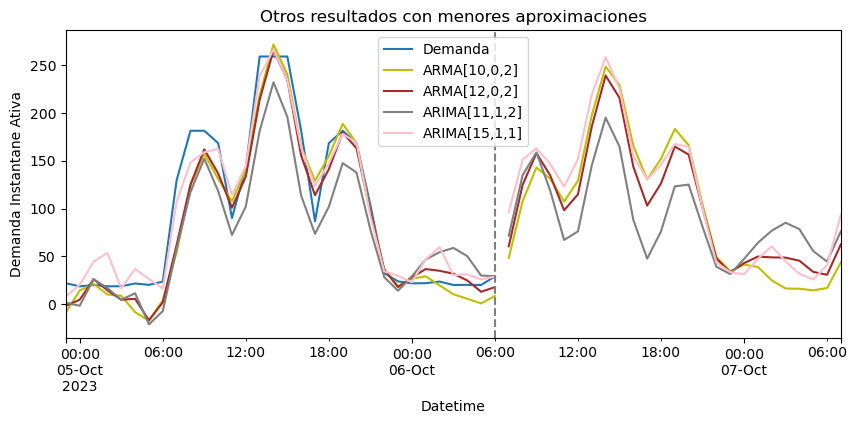

In [141]:
test['Demanda'].plot(figsize = (10,4), legend=True)
predsVarARIMA2.plot(label="ARMA[10,0,2]", color="y", legend=True)
forecastVarARIMA2.plot(color="y")
predsVarARIMA3.plot(label="ARMA[12,0,2]", color="brown", legend=True)
forecastVarARIMA3.plot(color="brown")
predsVarARIMA6.plot(label="ARIMA[11,1,2]", color="gray", legend=True)
forecastVarARIMA6.plot(color="gray")
predsVarARIMA7.plot(label="ARIMA[15,1,1]", color="pink", legend=True)
forecastVarARIMA7.plot(color="pink")

plt.axvline(x='2023-10-06 06:00:00', color='gray', linestyle='--', label='División Test/Predicción')
plt.title("Otros resultados con menores aproximaciones")
plt.ylabel("Demanda Instantane Ativa")

### Resumen mejor ARMA y ARIMA

Según la tabla anterior de resumen de variación de parámetros se muestra los modelos ARIMA probados y se obtuvieron los dos mejores modelos. Uno con I=0 y otro con I=0, es decir, tomando la serie original y la diferenciada.

In [142]:
df_ARIMA = df_ordenado.iloc[[0]].reset_index(drop=True)
df_ARIMA 

Modelo      Parámetros     AIC     BIC   RMSE    MAE
0  modeloVarARIMA4  p=24, d=1, q=0  633.59  689.45  12.39  10.48

In [143]:
df_ARMA = df_ordenado.iloc[[2]].reset_index(drop=True)
df_ARMA 

Modelo Parámetros     AIC     BIC   RMSE    MAE
0  modeloARMA  p=24, q=3  648.53  713.74  13.39  11.31

De todos los resultados variando los parámetros fue el (24,1,0).

## Diagnosis

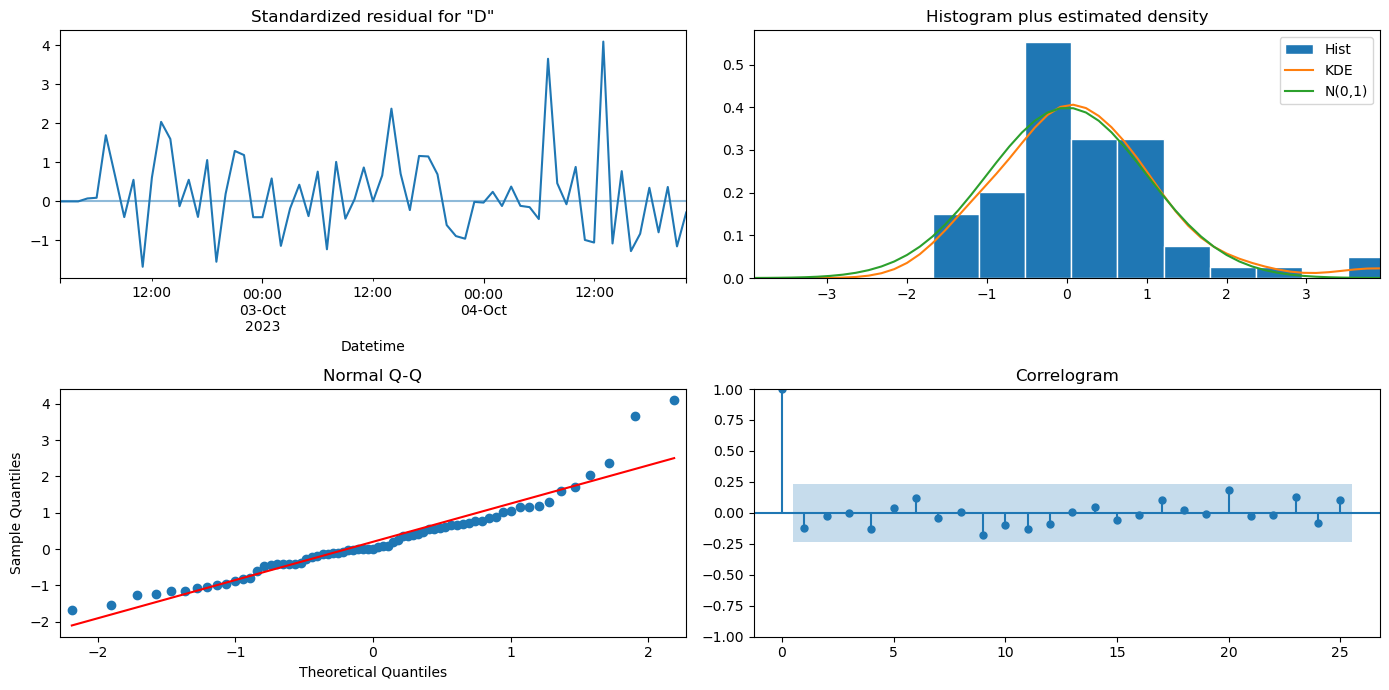

In [144]:
modeloVarARIMA4.plot_diagnostics(lags=25, figsize=(14, 7))
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsVarARIMA4.png")
plt.tight_layout()
plt.show()

## Creación del Gauge Chart 4

### Datos 4

In [145]:
valor_predito = forecastVarARIMA4[0]  # Se toma el primer dato de predicción futura

In [146]:
title = "ARIMA["+str(24)+','+str(1)+','+str(0)+"](Demanda Instantânea Ativa)"
figura = crear_figura_gauge(last_number, meta)
figura.show()
figura.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeVarARIMA4.png")

In [147]:
figura_tendencia = crear_figura_tendencia(valor_predito, last_number)
figura_tendencia.show()
figura_tendencia.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigARIMA.png")

## SARIMA

### auto_arima

Si tienes una serie de tiempo con patrones cíclicos, puedes considerar un enfoque diferente. Algunas opciones incluyen:

Modelos SARIMA: Si tu serie de tiempo exhibe patrones estacionales o cíclicos, puedes usar un modelo SARIMA (Seasonal ARIMA). SARIMA extiende ARIMA para incluir términos estacionales que pueden capturar patrones cíclicos. Estos modelos incluyen términos adicionales para modelar la estacionalidad de los datos. 

AIC                            391.398
BIC                            396.884

In [148]:
# if seleccion == "dataframe":
#     modeloAuARIMA0 = pm.auto_arima(train["Demanda"], # time series
#                                    m=24,
#                                    trace=True, # prints the information_criterion for each model it fits
#                                    error_action='ignore') # ignore orders that don't work

#     print(modeloAuARIMA0.summary())  # Print model summary

#     modeloAuARIMA0.fit()

Según el código del bloque anterior con m=24 y con menor criterio según AIC=391.39, el modelo que mejor se ajusta es ARIMA(2,0,0)(0,1,0)[24].

In [149]:
if seleccion == "dataframe":
    p=2
    d=0
    q=0
    P=0
    D=1
    Q=0
    m=24
    
else:
    p=3
    d=1
    q=3
    P=2
    D=0
    Q=3
    m=24

In [150]:
modeloAuSARIMA = ARIMA(train['Demanda'], order = (p,d,q), seasonal_order = (P,D,Q,m)).fit()
# modeloAuSARIMA.summary()

In [151]:
predsAuSARIMA = modeloAuSARIMA.predict(start = len(train), end = len(df)-1).rename("Prediction")

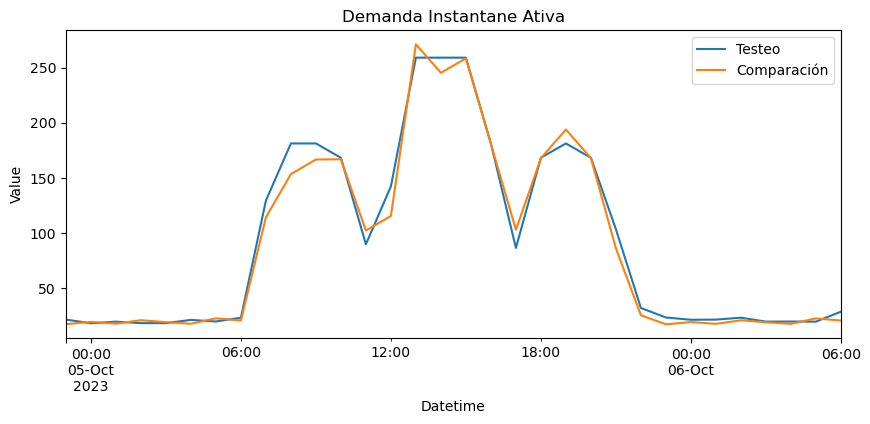

In [152]:
test['Demanda'].plot(figsize = (10,4), label="Testeo")
predsAuSARIMA.plot(label="Comparación")
plt.title("Demanda Instantane Ativa")
plt.ylabel("Value")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotComAuARIMA0.png")

In [153]:
rmseAuSARIMA = np.sqrt(mean_squared_error(test["Demanda"], predsAuSARIMA))  # Cálculo del RMSE
maeAuSARIMA = mean_absolute_error(test["Demanda"], predsAuSARIMA)  # Cálculo del MAE

print(f'RMSE: {rmseAuSARIMA}')
print(f'MAE: {maeAuSARIMA}')

RMSE: 10.306865838745319
MAE: 7.085947488010237


In [154]:
forecastAuSARIMA = modeloAuSARIMA.predict(start=len(df), end=len(df)+muestras)  # Forecast -Se pronóstica valores en un día

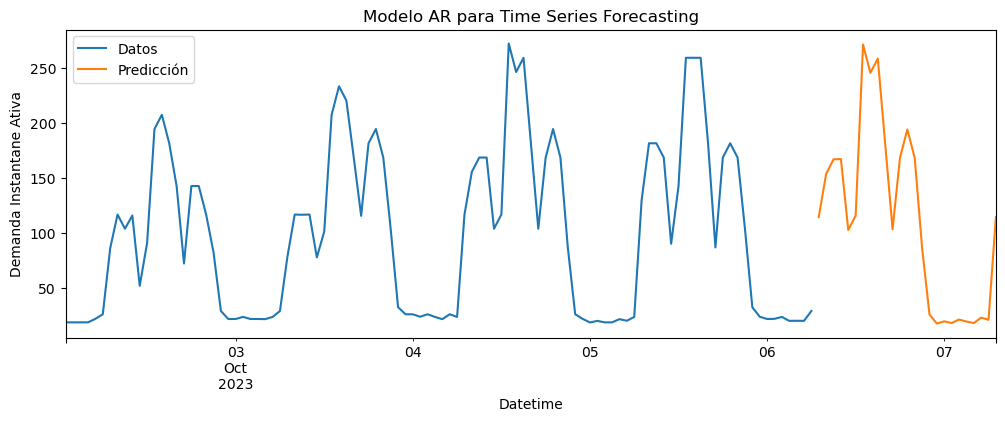

In [155]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuSARIMA.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForModAR.png")

In [156]:
df_resultsSARIMA = pd.DataFrame(columns=['Modelo', 'Parámetros', 'AIC', 'BIC', 'RMSE', 'MAE'])

fila_SARIMA = {
    'Modelo': 'modeloSARIMA',
    'Parámetros': 'p=2, d=0, q=0, P=0, D=1, q=0',
    'AIC': modeloAuSARIMA.aic,
    'BIC': modeloAuSARIMA.bic,
    'RMSE': rmseAuSARIMA,
    'MAE': maeAuSARIMA
}

nueva_fila_df = pd.DataFrame([fila_SARIMA])
df_resultsSARIMA = pd.concat([df_resultsSARIMA, nueva_fila_df], ignore_index=True)

df_SARIMA = df_resultsSARIMA.sort_values(by='RMSE').round(2)
df_SARIMA

Modelo                    Parámetros    AIC     BIC   RMSE   MAE
0  modeloSARIMA  p=2, d=0, q=0, P=0, D=1, q=0  391.4  396.88  10.31  7.09

## Diagnosis

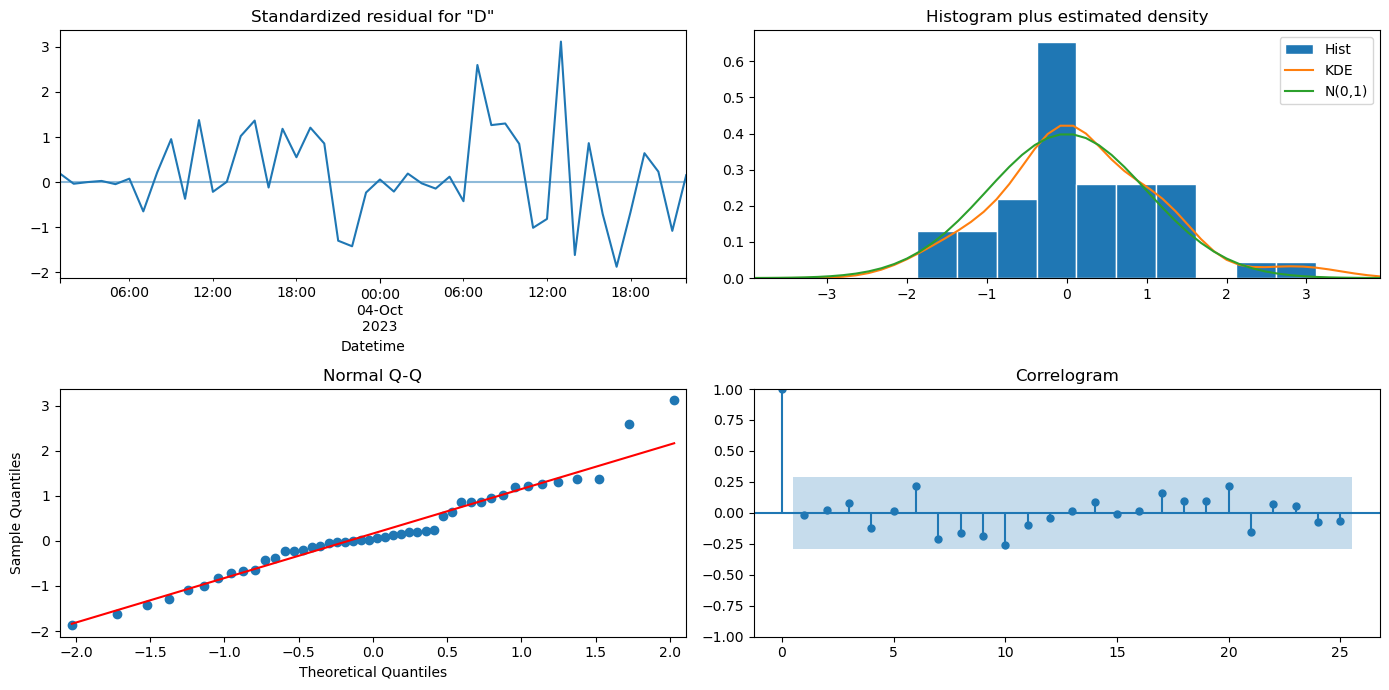

In [157]:
modeloAuSARIMA.plot_diagnostics(lags=25, figsize=(14, 7))
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsAuARIMA.png")
plt.tight_layout()
plt.show()

## *Creación del Gauge Chart 4*

## Datos 4

In [158]:
valor_predito = forecastAuSARIMA[0]  # Se toma el primer dato de predicción futura

In [159]:
title = "SARIMA["+str(2)+','+str(0)+','+str(0)+"]["+str(0)+','+str(1)+','+str(0)+"](Demanda Instantânea Ativa)"
figura = crear_figura_gauge(last_number, meta)
figura.show()
figura.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge2.png")

In [160]:
figura_tendencia = crear_figura_tendencia(valor_predito, last_number)
figura_tendencia.show()
figura_tendencia.write_image(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure2.png")

## SARIMAX (exog=Temperatura, Unidad)

El p-valor (p-value) es una medida estadística que se utiliza en el contexto de pruebas de hipótesis en regresión, incluyendo modelos como la regresión lineal o SARIMAX con variables exógenas. Cuando se agrega una variable exógena al modelo, el p-valor asociado con esa variable exógena en una prueba específica llamada prueba t o t-test, generalmente indica si la variable exógena es estadísticamente significativa en la predicción del resultado (variable dependiente) o no.

El p-valor en el contexto de la regresión con variables exógenas se interpreta de la siguiente manera:

Un p-valor bajo (generalmente, p-valor < 0.05) sugiere que la variable exógena es estadísticamente significativa en el modelo. Esto significa que hay evidencia de que la variable exógena tiene un efecto significativo en la variable dependiente, y su inclusión mejora el ajuste del modelo.

Un p-valor alto (generalmente, p-valor ≥ 0.05) sugiere que la variable exógena no es estadísticamente significativa en el modelo. Esto significa que no hay evidencia sólida de que la variable exógena tenga un efecto significativo en la variable dependiente, y su inclusión en el modelo puede no ser justificada desde una perspectiva estadística.

En resumen, el p-valor se utiliza para determinar si una variable exógena aporta información significativa al modelo. Si el p-valor es bajo, es más probable que la variable exógena sea relevante y contribuya al modelo. Si el p-valor es alto, la variable exógena podría no ser necesaria en el modelo o podría no estar relacionada de manera significativa con la variable dependiente.

AIC	391.398
BIC	396.884

#### exog=Temperatura

In [161]:
modeloAuSARIMAX1 = SARIMAX(train["Demanda"], order=(2, 0, 0), seasonal_order=(0, 1, 0, 24), exog=train["Temperatura"]).fit(disp=False)
#modeloAuSARIMAXT.summary()

In [162]:
predsAuSARIMAX1 = modeloAuSARIMAX1.predict(start = len(train), end = len(df)-1, exog=test["Temperatura"])

<Axes: xlabel='Datetime'>

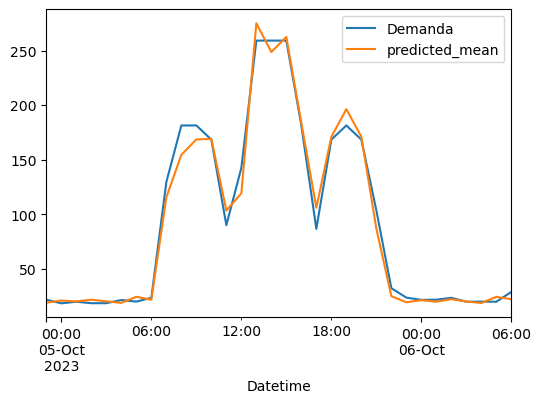

In [163]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuSARIMAX1.plot(legend = True)

In [164]:
rmseAuSARIMAX1 = np.sqrt(mean_squared_error(test["Demanda"], predsAuSARIMAX1))  # Cálculo del RMSE
maeAuSARIMAX1 = mean_absolute_error(test["Demanda"], predsAuSARIMAX1)  # Cálculo del MAE

print(f'RMSE: {rmseAuSARIMAX1}')
print(f'MAE: {maeAuSARIMAX1}')

RMSE: 10.113211300907114
MAE: 7.054206915117874


In [165]:
forecastAuSARIMAX1 = modeloAuSARIMAX1.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df["Temperatura"].head(57))

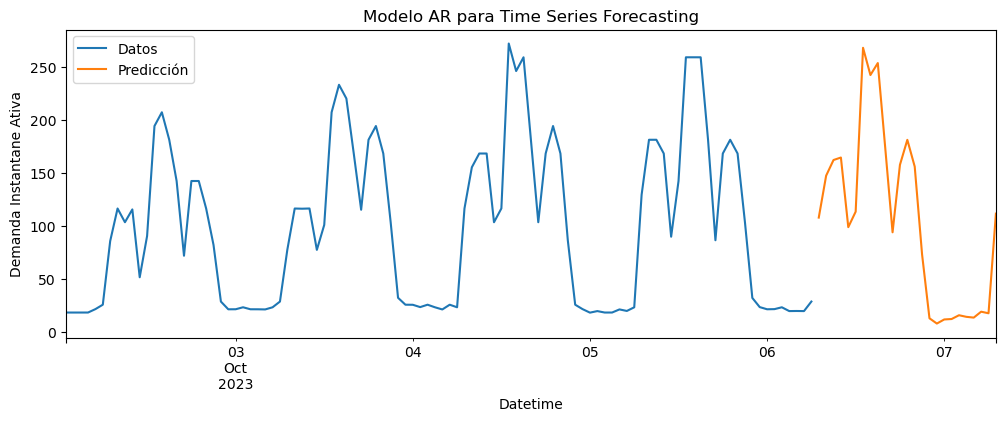

In [166]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuSARIMAX1.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

#### exog = Unidad

In [167]:
modeloAuSARIMAX2 = SARIMAX(train["Demanda"], order=(2, 0, 0), seasonal_order=(0, 1, 0, 24), exog=train["Unidad"]).fit(disp=False)
#modeloAuSARIMAXU.summary()

In [168]:
predsAuSARIMAX2 = modeloAuSARIMAX2.predict(start = len(train), end = len(df)-1, exog=test["Unidad"])

<Axes: xlabel='Datetime'>

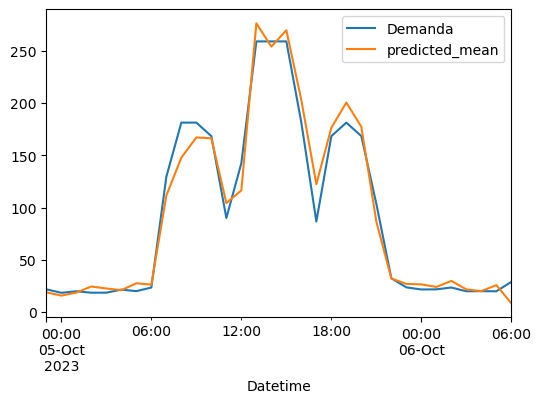

In [169]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuSARIMAX2.plot(legend = True)

In [170]:
rmseAuSARIMAX2 = np.sqrt(mean_squared_error(test["Demanda"], predsAuSARIMAX2))  # Cálculo del RMSE
maeAuSARIMAX2 = mean_absolute_error(test["Demanda"], predsAuSARIMAX2)  # Cálculo del MAE

print(f'RMSE: {rmseAuSARIMAX2}')
print(f'MAE: {maeAuSARIMAX2}')

RMSE: 13.910282970511766
MAE: 10.135311523436714


In [171]:
forecastAuSARIMAX2 = modeloAuSARIMAX2.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df["Unidad"].head(57))

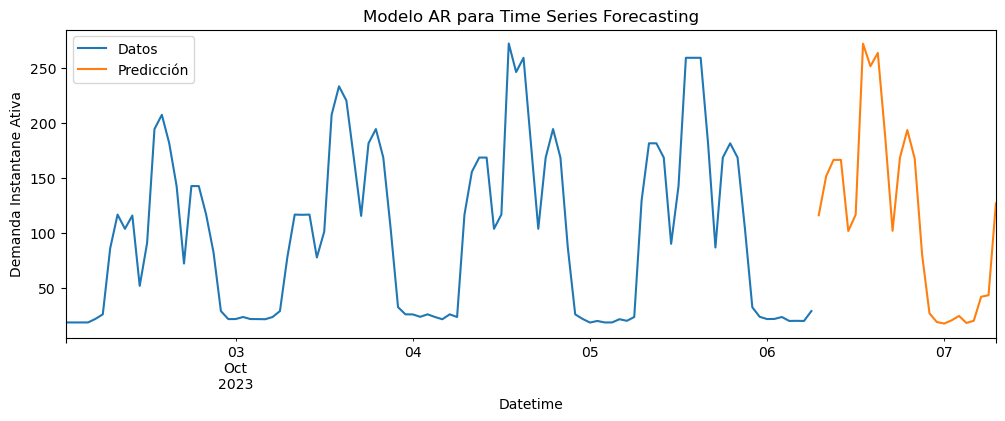

In [172]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuSARIMAX2.plot(label="Predicción")
plt.title("Modelo AR para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForModAR.png")

#### exog = Temperatura, Unidad

In [173]:
modeloAuSARIMAX3 = SARIMAX(train["Demanda"], order=(2, 0, 0), seasonal_order=(0, 1, 0, 24), exog=train[["Temperatura", "Unidad"]]).fit(disp=False)
#modeloAuSARIMAX.summary()

In [174]:
predsAuSARIMAX3 = modeloAuSARIMAX3.predict(start = len(train), end = len(df)-1, exog=test[["Temperatura", "Unidad"]])

<Axes: xlabel='Datetime'>

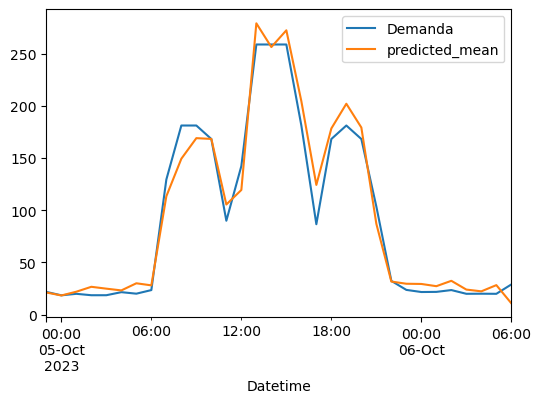

In [175]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuSARIMAX3.plot(legend = True)

In [176]:
rmseAuSARIMAX3 = np.sqrt(mean_squared_error(test["Demanda"], predsAuSARIMAX3))  # Cálculo del RMSE
maeAuSARIMAX3 = mean_absolute_error(test["Demanda"], predsAuSARIMAX3)  # Cálculo del MAE

print(f'RMSE: {rmseAuSARIMAX3}')
print(f'MAE: {maeAuSARIMAX3}')

RMSE: 14.31330818378234
MAE: 10.923711637484512


In [177]:
forecastAuSARIMAX3 = modeloAuSARIMAX3.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df[["Temperatura","Unidad"]].head(57)) # Forecast -Se pronóstica valores en un día

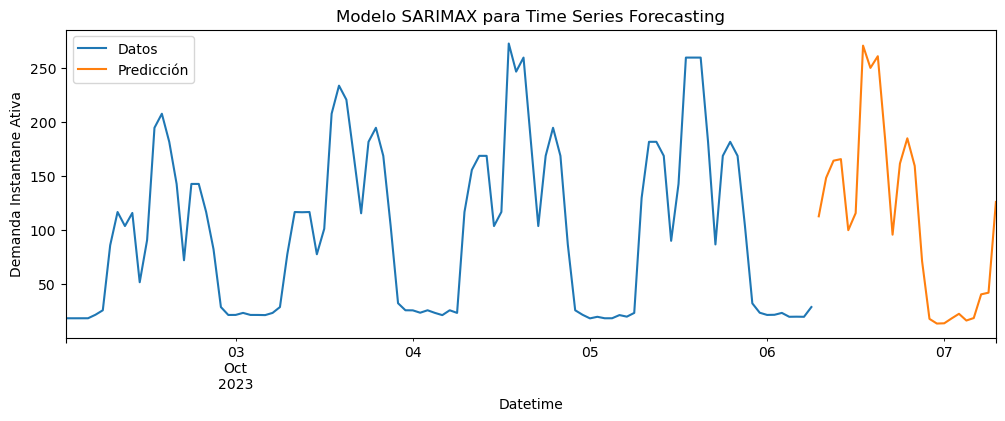

In [178]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuSARIMAX3.plot(label="Predicción")
plt.title("Modelo SARIMAX para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotForModAR.png")

In [179]:
modelos = [modeloAuSARIMAX1, modeloAuSARIMAX2, modeloAuSARIMAX3]

parametros = []  # Crear una lista de valores de los parámetros para cada modelo
for modelo in modelos:
    ar_order = modelo.model_orders["ar"]
    ma_order = modelo.model_orders["ma"]
    i_order = modelo.model_orders["trend"]
    P_order = modelo.model_orders["seasonal_ar"]
    Q_order = modelo.model_orders["seasonal_ma"]
    D_order = modelo.model_orders["variance"]
    parametros_texto = f'p={ar_order}, d={i_order}, q={ma_order}, P={P_order}, D={D_order}, Q={Q_order}'
    parametros.append(parametros_texto)

df_resultados = pd.DataFrame({'Modelo': [f'modeloSARIMAX{i+1}' for i in range(len(modelos))],  # Crear el DataFrame con modelos, métricas y la columna "Parámetros"
                              'Parámetros': parametros,
                              'Variables exógenas': ['Temperatura', 'Unidad', 'Temperatura y Unidad'],
                              'AIC': [modelo.aic for modelo in modelos],
                              'BIC': [modelo.bic for modelo in modelos],
                              'RMSE': [rmseAuSARIMAX1, rmseAuSARIMAX2, rmseAuSARIMAX3],
                              'MAE': [maeAuSARIMAX1, maeAuSARIMAX2, maeAuSARIMAX3]
                              })

df_AuSARIMAX = df_resultados.sort_values(by='RMSE').round(2)  # Ordenar el DataFrame por el valor de RMSE en orden ascendente (menor a mayor) y redondear los valores

df_AuSARIMAX  # Imprimir el DataFrame ordenado

Modelo                    Parámetros    Variables exógenas     AIC  \
0  modeloSARIMAX1  p=2, d=0, q=0, P=0, D=1, Q=0           Temperatura  392.98   
1  modeloSARIMAX2  p=2, d=0, q=0, P=0, D=1, Q=0                Unidad  387.66   
2  modeloSARIMAX3  p=2, d=0, q=0, P=0, D=1, Q=0  Temperatura y Unidad  389.26   

      BIC   RMSE    MAE  
0  400.29  10.11   7.05  
1  394.98  13.91  10.14  
2  398.41  14.31  10.92

In [180]:
df_SARIMAX = df_AuSARIMAX.iloc[0:1]

## ARIMAX

In [181]:
modeloAuARIMAX1 = SARIMAX(train["Demanda"], order=(24, 1, 0), exog=train[["Temperatura"]]).fit(disp=False)
#modeloAuSARIMAX.summary()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [182]:
predsAuARIMAX1 = modeloAuARIMAX1.predict(start = len(train), end = len(df)-1, exog=test[["Temperatura"]])

<Axes: xlabel='Datetime'>

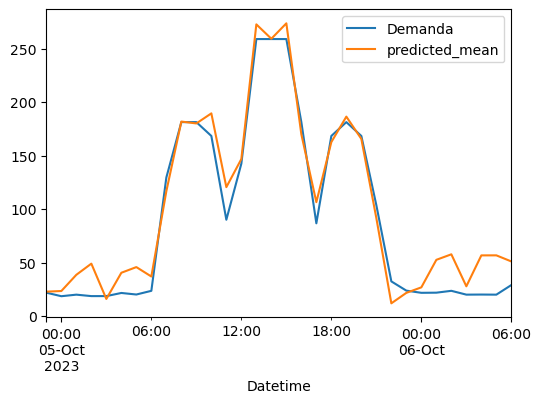

In [183]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuARIMAX1.plot(legend = True)

In [184]:
rmseAuARIMAX1 = np.sqrt(mean_squared_error(test["Demanda"], predsAuARIMAX1))  # Cálculo del RMSE
maeAuARIMAX1 = mean_absolute_error(test["Demanda"], predsAuARIMAX1)  # Cálculo del MAE

print(f'RMSE: {rmseAuARIMAX1}')
print(f'MAE: {maeAuARIMAX1}')

RMSE: 18.55288445782708
MAE: 14.61724511247263


In [185]:
forecastAuARIMAX1 = modeloAuARIMAX1.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df[["Temperatura"]].head(57)) # Forecast -Se pronóstica valores en un día

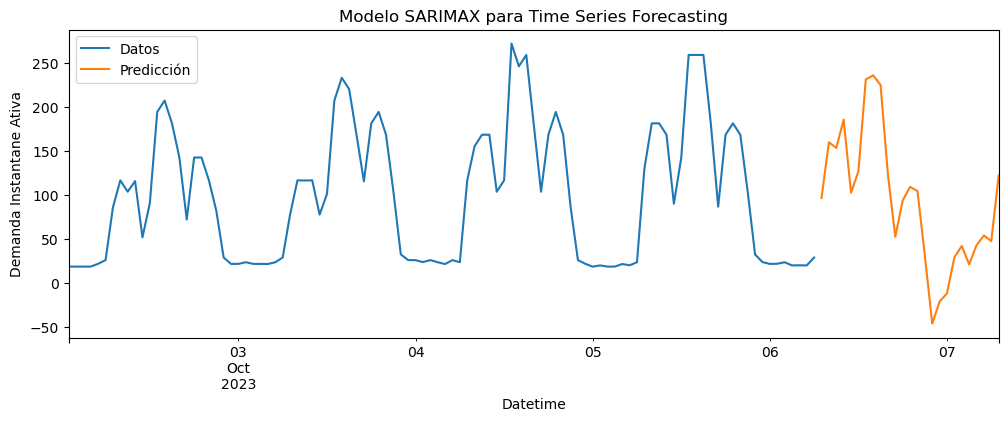

In [186]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuARIMAX1.plot(label="Predicción")
plt.title("Modelo SARIMAX para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [187]:
modeloAuARIMAX2 = SARIMAX(train["Demanda"], order=(24, 1, 0), exog=train[["Unidad"]]).fit(disp=False)
#modeloAuSARIMAX.summary()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [188]:
predsAuARIMAX2 = modeloAuARIMAX2.predict(start = len(train), end = len(df)-1, exog=test[["Unidad"]])

<Axes: xlabel='Datetime'>

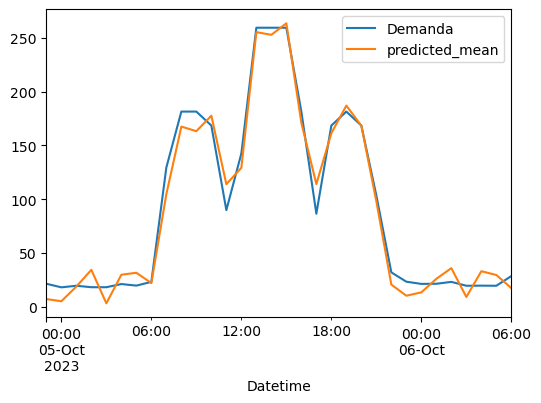

In [189]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuARIMAX2.plot(legend = True)

In [190]:
rmseAuARIMAX2 = np.sqrt(mean_squared_error(test["Demanda"], predsAuARIMAX2))  # Cálculo del RMSE
maeAuARIMAX2 = mean_absolute_error(test["Demanda"], predsAuARIMAX2)  # Cálculo del MAE

print(f'RMSE: {rmseAuARIMAX2}')
print(f'MAE: {maeAuARIMAX2}')

RMSE: 12.682753364033342
MAE: 10.90603054913399


In [191]:
forecastAuARIMAX2 = modeloAuARIMAX2.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df[["Unidad"]].head(57)) # Forecast -Se pronóstica valores en un día

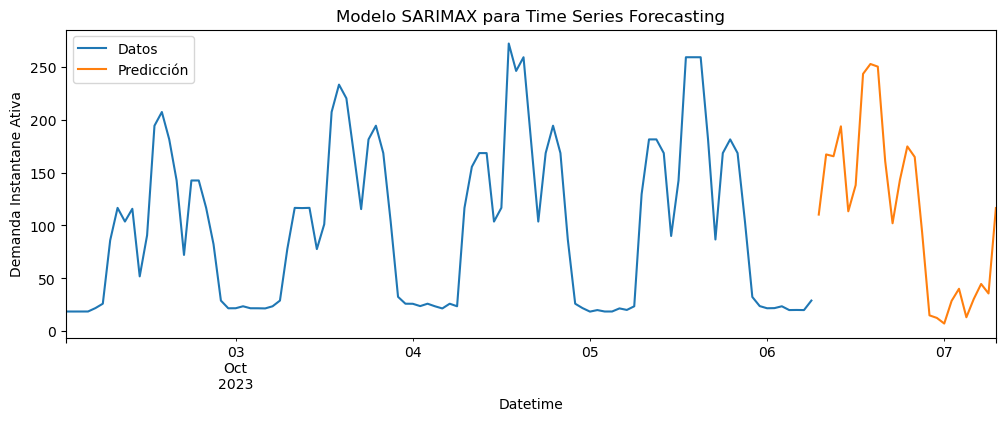

In [192]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuARIMAX2.plot(label="Predicción")
plt.title("Modelo SARIMAX para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [193]:
modeloAuARIMAX3 = SARIMAX(train["Demanda"], order=(24, 1, 0), exog=train[["Temperatura", "Unidad"]]).fit(disp=False)
#modeloAuSARIMAX.summary()

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\juanm\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [194]:
predsAuARIMAX3 = modeloAuARIMAX3.predict(start = len(train), end = len(df)-1, exog=test[["Temperatura", "Unidad"]])

<Axes: xlabel='Datetime'>

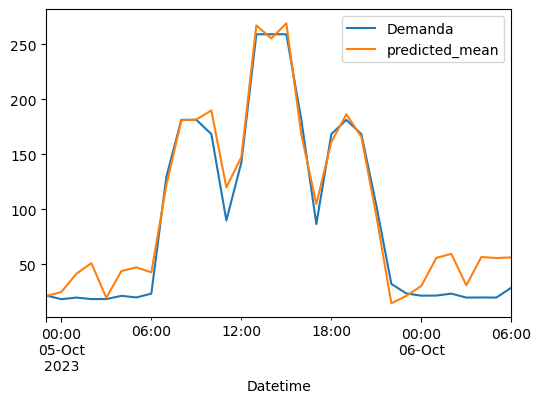

In [195]:
test['Demanda'].plot(figsize = (6,4), legend=True)
predsAuARIMAX3.plot(legend = True)

In [196]:
rmseAuARIMAX3 = np.sqrt(mean_squared_error(test["Demanda"], predsAuARIMAX3))  # Cálculo del RMSE
maeAuARIMAX3 = mean_absolute_error(test["Demanda"], predsAuARIMAX3)  # Cálculo del MAE

print(f'RMSE: {rmseAuARIMAX3}')
print(f'MAE: {maeAuARIMAX3}')

RMSE: 19.298336287631994
MAE: 15.137806392893912


In [197]:
forecastAuARIMAX3 = modeloAuARIMAX3.predict(start='2023-10-06 07:00:00', end='2023-10-07 07:00:00', exog=df[["Temperatura", "Unidad"]].head(57)) # Forecast -Se pronóstica valores en un día

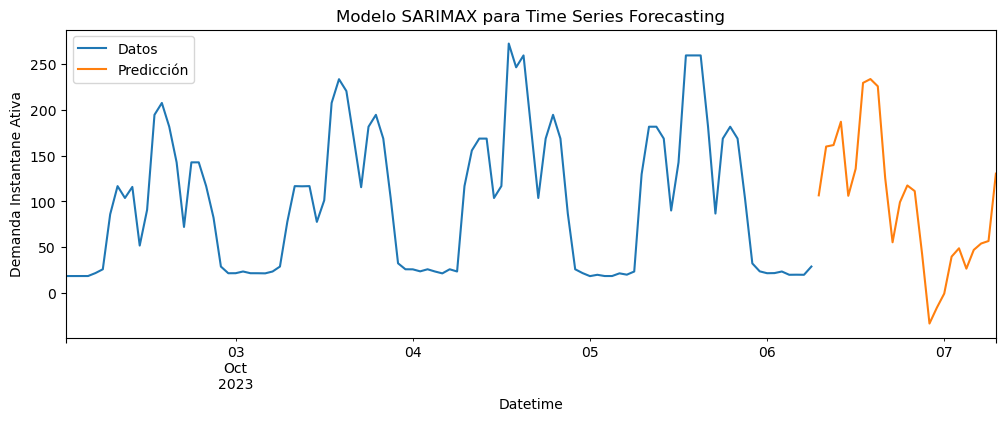

In [198]:
df["Demanda"].plot(label="Datos")  # Gráfica
forecastAuARIMAX3.plot(label="Predicción")
plt.title("Modelo SARIMAX para Time Series Forecasting")
plt.ylabel("Demanda Instantane Ativa")
plt.legend()

In [199]:
modelos = [modeloAuARIMAX1, modeloAuARIMAX2, modeloAuARIMAX3]
rmseAuARIMAX = [rmseAuARIMAX1, rmseAuARIMAX2, rmseAuARIMAX3]
maeAuARIMAX = [maeAuARIMAX1, maeAuARIMAX2, maeAuARIMAX3]
var = ["Temperatura", "Unidad", "Temperatura y Unidad"]

df_resultsARIMAX = pd.DataFrame(columns=['Modelo', 'Parámetros', 'Variables exógenas', 'AIC', 'BIC', 'RMSE', 'MAE'])

for i, modelo in enumerate(modelos):
    aic = modelo.aic
    bic = modelo.bic
    rmse = rmseAuARIMAX[i]  
    mae = maeAuARIMAX[i]
    
    fila_ARIMAX = {
        'Modelo': f'modeloARIMAX{i + 1}',
        'Parámetros': "p=24, d=1, q=0",
        'Variables exógenas': var[i],
        'AIC': aic,
        'BIC': bic,
        'RMSE': rmse,
        'MAE': mae
    }

    nueva_fila_df = pd.DataFrame([fila_ARIMAX])
    df_resultsARIMAX = pd.concat([df_resultsARIMAX, nueva_fila_df], ignore_index=True)

df_AuARIMAX = df_resultsARIMAX.sort_values(by='RMSE').round(2)

df_AuARIMAX

Modelo      Parámetros    Variables exógenas     AIC     BIC   RMSE  \
1  modeloARIMAX2  p=24, d=1, q=0                Unidad  634.80  692.89  12.68   
0  modeloARIMAX1  p=24, d=1, q=0           Temperatura  637.09  695.17  18.55   
2  modeloARIMAX3  p=24, d=1, q=0  Temperatura y Unidad  638.64  698.96  19.30   

     MAE  
1  10.91  
0  14.62  
2  15.14

In [200]:
df_ARIMAX = df_AuARIMAX.iloc[0:1]

df_ARIMAX = df_ARIMAX.reset_index(drop=True)

df_ARIMAX

Modelo      Parámetros Variables exógenas    AIC     BIC   RMSE  \
0  modeloARIMAX2  p=24, d=1, q=0             Unidad  634.8  692.89  12.68   

     MAE  
0  10.91

# Resumen

In [201]:
dataframes = {'AR': df_AR, 'ARMA': df_ARMA, 'ARIMA': df_ARIMA, 'SARIMA': df_SARIMA, 'SARIMAX': df_SARIMAX, 'ARIMAX': df_ARIMAX}

df_concatenado = pd.concat(dataframes, axis=0)

df_ordenado = df_concatenado.sort_values(by='RMSE')

df_ordenado

Modelo                    Parámetros     AIC     BIC  \
SARIMAX 0   modeloSARIMAX1  p=2, d=0, q=0, P=0, D=1, Q=0  392.98  400.29   
SARIMA  0     modeloSARIMA  p=2, d=0, q=0, P=0, D=1, q=0  391.40  396.88   
ARIMA   0  modeloVarARIMA4                p=24, d=1, q=0  633.59  689.45   
ARIMAX  0    modeloARIMAX2                p=24, d=1, q=0  634.80  692.89   
ARMA    0       modeloARMA                     p=24, q=3  648.53  713.74   
AR      0         modeloAR                          p=24  413.31  460.85   

            RMSE    MAE Variables exógenas  
SARIMAX 0  10.11   7.05        Temperatura  
SARIMA  0  10.31   7.09                NaN  
ARIMA   0  12.39  10.48                NaN  
ARIMAX  0  12.68  10.91             Unidad  
ARMA    0  13.39  11.31                NaN  
AR      0  19.94  16.25                NaN

#### Se grafican los 3 primeros

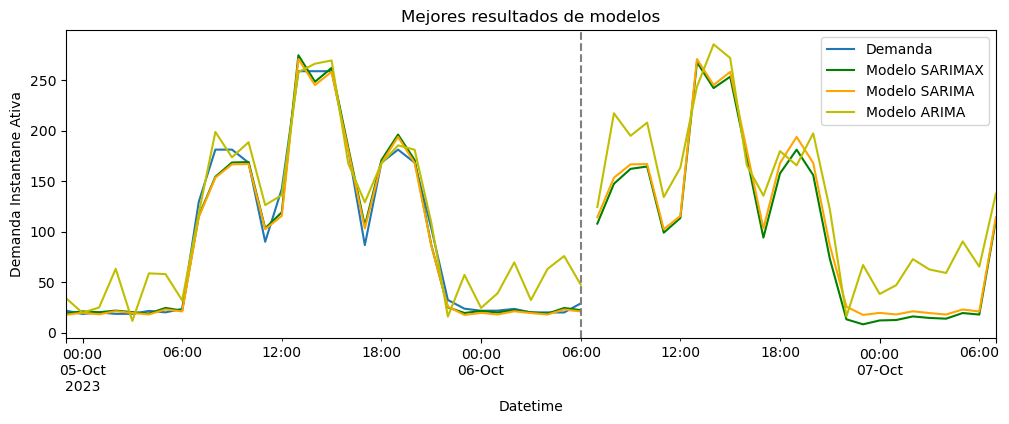

In [205]:
test['Demanda'].plot(legend=True)

predsAuSARIMAX1.plot(label = "Modelo SARIMAX", legend = True, color="green")
predsAuSARIMA.plot(label = "Modelo SARIMA", legend = True, color="orange")
predsARIMA.plot(label = "Modelo ARIMA", legend = True, color="y")

forecastAuSARIMAX1.plot(color="green")
forecastAuSARIMA.plot(color="orange")
forecastARIMA.plot(color="y")

plt.axvline(x='2023-10-06 06:00:00', color='gray', linestyle='--', label='División Test/Predicción')
plt.title("Mejores resultados de modelos")
plt.ylabel("Demanda Instantane Ativa")
plt.savefig(r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotMejor.png")

#### Se grafican los 3 últimos

<Axes: xlabel='Datetime'>

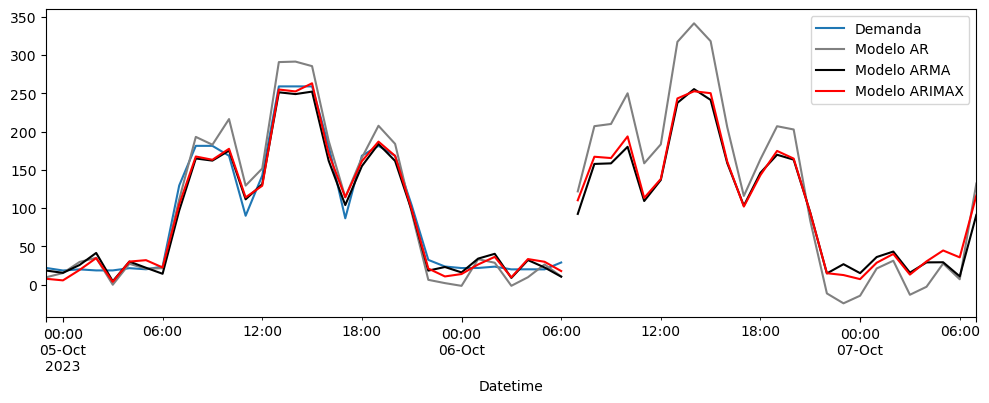

In [203]:
test['Demanda'].plot(legend=True)
predsAR.plot(label = "Modelo AR", legend = True, color="gray")
predsARMA.plot(label = "Modelo ARMA", legend = True, color="black")
predsAuARIMAX2.plot(label = "Modelo ARIMAX", legend = True, color="red")

forecastAR.plot(color="gray")
forecastARMA.plot(color="black")
forecastAuARIMAX2.plot(color="red")

# Ventana

In [204]:
## Función para cargar y colocar una imagen en el lienzo
def cargar_y_colocar_imagen(ventana, ruta_imagen, fila, columna, rowspan=1, columnspan=5):
    imagen = PhotoImage(file=ruta_imagen)
    imagen = imagen.subsample(2, 2)  # Ajusta el tamaño de la imagen según tus necesidades
    label = Label(ventana, image=imagen, borderwidth=0,  height=200, width=300)
    label.image = imagen  # Mantén una referencia a la imagen
    label.grid(row=fila, column=columna, rowspan=rowspan, columnspan=columnspan, padx=1, pady=1)

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Demanda Instantânea Ativa")
ventana.config(bg="white")
ventana.geometry("1200x610")
ventana.resizable(0,2)

# Crear un Frame para contener el lienzo
frame = ttk.Frame(ventana)
frame.pack(fill=tk.BOTH, expand=True)

# Agregar un lienzo al Frame con Scrollbars
lienzo = tk.Canvas(frame, bg="white")
lienzo.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# Agregar un Scrollbar vertical
scrollbar = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=lienzo.yview)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# Configurar el lienzo para que funcione con el Scrollbar
lienzo.configure(yscrollcommand=scrollbar.set)

# Crear un Frame dentro del lienzo para contener las imágenes
contenido = tk.Frame(lienzo, bg="white")
lienzo.create_window((0, 0), window=contenido, anchor=tk.NW)

# Lista de rutas de imágenes
rutas_imagenes = [
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeAR.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeARMA.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGaugeARIMA0.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureGauge.png"
]

# Número de columnas y filas
num_columnas = 20  # 4 columnas (3 imágenes + 1 espacio)
num_filas = 6

# Calcular el número total de imágenes
total_imagenes = 9

# Columna y fila inicial para colocar las imágenes
columna_actual = 0
fila_actual = 0

for i in range(total_imagenes):
    cargar_y_colocar_imagen(contenido, rutas_imagenes[i], fila=fila_actual, columna=columna_actual, rowspan=1, columnspan=5)
    columna_actual += 7

    # Agregar una columna de espacio en blanco después de cada imagen
    if columna_actual % (num_columnas + 1) == 0:
        columna_actual += 0
        fila_actual += 1
        
    if columna_actual >= (num_columnas + 1):
        columna_actual = 0
        fila_actual += 1



        
        
        
# Función para cargar y colocar una imagen en la ventana
def cargar_y_colocar_imagen2(ventana, ruta_imagen, fila, columna, rowspan=1, columnspan=1):
    imagen = PhotoImage(file=ruta_imagen)
    imagen = imagen.subsample(8, 8)  # Ajusta el tamaño de la imagen según tus necesidades
    label = Label(ventana, image=imagen, borderwidth=0)
    label.image = imagen  # Mantén una referencia a la imagen
    label.grid(row=fila, column=columna, rowspan=rowspan, columnspan=columnspan, padx=1, pady=1)

# Lista de rutas de imágenes
rutas_imagenes2 = [
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigAR.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigARMA.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigARIMA0.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure2.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure.png",
    r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureFigure.png",
]

# Columna y fila inicial para colocar las imágenes
columna_actual = 5
fila_actual = 0

for i in range(total_imagenes):
    cargar_y_colocar_imagen2(contenido, rutas_imagenes2[i], fila=fila_actual, columna=columna_actual, rowspan=1, columnspan=1)
    columna_actual += 7

    if columna_actual >= num_columnas:
        columna_actual = 5
        fila_actual += 2


# Imagen Insight(Cambio)
imgInsight0000 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotACFePACFOriginal.png")
imgInsight0000 = imgInsight0000.subsample(1, 1)
imgInsight0001 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\decomposeOriginal.png")
imgInsight0001 = imgInsight0001.subsample(1, 1)
imgInsight0010 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotDiagnosticsAR.png")
imgInsight0010 = imgInsight0010.subsample(1, 1)


imgAnalytics00 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotTimeSeries.png")

# Abrir imagen con ventana
def VentanaInsight00():
    ventanaInsight00 = tk.Toplevel()
    ventanaInsight00.title("Analitycs") # Título de la ventana
    ventanaInsight00.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight00.resizable(0, 0) # Con 0 0 no se puede ampliar ni horizontal ni verticalmente
    ventanaInsight00.geometry("800x650")
    
    label_img1 = Label(ventanaInsight00, image=imgInsight0000)
    label_img2 = Label(ventanaInsight00, image=imgInsight0001)     
    label_img3 = Label(ventanaInsight00, image=imgInsight0010)
    
    label_img1.grid(row=0, column=0, columnspan=2)
    label_img2.grid(row=1, column=0)
    label_img3.grid(row=1, column=1)
 
       
    
# Abrir imagen con ventana
def VentanaAnalitycs00():
    ventanaAnalitycs00 = tk.Toplevel()
    ventanaAnalitycs00.title("Analitycs") # Título de la ventana
    ventanaAnalitycs00.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs00.resizable(0, 0) # Con 0 0 no se puede ampliar ni horizontal ni verticalmente

    Label(ventanaAnalitycs00, image = imgAnalytics00, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs00.boton_listo = ttk.Button(ventanaAnalitycs00, text="Ok!", command=ventanaAnalitycs00.destroy).grid(row = 1, column = 0, pady=5, padx=1)  


    
# Imagen Insight
imgInsight0100 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\imagenOriginal2.png") # Imagen orginal
imgInsight0100 = imgInsight0100.subsample(3, 3)
imgInsight0101 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\Comparacion.png")
imgInsight0101 = imgInsight0101.subsample(2, 2)
imgInsight0110 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\Otra.png")
imgInsight0110 = imgInsight0110.subsample(2, 2)
imgInsight0111 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\Ultima.png")
imgInsight0111 = imgInsight0111.subsample(3, 3)


imgAnalytics01 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\plotTimeSeries2.png")
imgAnalytics01 = imgAnalytics01.subsample(2, 2)

def VentanaInsight01():
    ventanaInsight01= tk.Toplevel()
    ventanaInsight01.title("Analitycs") # Título de la ventana
    ventanaInsight01.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight01.resizable(0, 0) # Con 0 0 no se puede ampliar ni horizontal ni verticalmente
    
    # Crear widgets Label para mostrar las imágenes
    label_img1 = Label(ventanaInsight01, image=imgInsight0100)
    label_img2 = Label(ventanaInsight01, image=imgInsight0101)
    label_img3 = Label(ventanaInsight01, image=imgInsight0110)
    label_img4 = Label(ventanaInsight01, image=imgInsight0111)

    # Colocar las imágenes en una cuadrícula 2x2
    label_img1.grid(row=0, column=0, padx=10, pady=10)
    label_img2.grid(row=0, column=1, padx=10, pady=10)
    label_img3.grid(row=1, column=0, padx=10, pady=10)
    label_img4.grid(row=1, column=1, padx=10, pady=10)

    # Botón para cerrar la ventana
    ventanaInsight01.boton_listo = ttk.Button(ventanaInsight01, text="Ok!", command=ventanaInsight01.destroy)
    ventanaInsight01.boton_listo.grid(row=2, column=0, columnspan=2, padx=10, pady=10)   
    

# Abrir imagen con ventana
def VentanaAnalitycs01():
    ventanaAnalitycs01 = tk.Toplevel()
    ventanaAnalitycs01.title("Analitycs") # Título de la ventana
    ventanaAnalitycs01.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs01.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    
    Label(ventanaAnalitycs01, image = imgAnalytics01, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs01.boton_listo = ttk.Button(ventanaAnalitycs01, text="Ok!", command=ventanaAnalitycs01.destroy).grid(row = 1, column = 0, pady=5, padx=1)

# Abrir imagen con ventana
def VentanaAnalitycs02():
    ventanaAnalitycs02 = tk.Toplevel()
    ventanaAnalitycs02.title("Analitycs") # Título de la ventana
    ventanaAnalitycs02.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs02.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs02, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs02.boton_listo = ttk.Button(ventanaAnalitycs02, text="Ok!", command=ventanaAnalitycs02.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight02():
    ventanaInsight02 = tk.Toplevel()
    ventanaInsight02.title("Analitycs") # Título de la ventana
    ventanaInsight02.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight02.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight02, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight02.boton_listo = ttk.Button(ventanaInsight02, text="Ok!", command=ventanaInsight02.destroy).grid(row = 1, column = 0, pady=5, padx=1)

    
# Abrir imagen con ventana
def VentanaAnalitycs10():
    ventanaAnalitycs10 = tk.Toplevel()
    ventanaAnalitycs10.title("Analitycs") # Título de la ventana
    ventanaAnalitycs10.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs10.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs10, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs10.boton_listo = ttk.Button(ventanaAnalitycs10, text="Ok!", command=ventanaAnalitycs10.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight10():
    ventanaInsight10 = tk.Toplevel()
    ventanaInsight10.title("Analitycs") # Título de la ventana
    ventanaInsight10.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight10.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight10, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight10.boton_listo = ttk.Button(ventanaInsight10, text="Ok!", command=ventanaInsight10.destroy).grid(row = 1, column = 0, pady=5, padx=1)

# Abrir imagen con ventana
def VentanaAnalitycs11():
    ventanaAnalitycs11 = tk.Toplevel()
    ventanaAnalitycs11.title("Analitycs") # Título de la ventana
    ventanaAnalitycs11.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs11.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs11, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs11.boton_listo = ttk.Button(ventanaAnalitycs11, text="Ok!", command=ventanaAnalitycs11.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight11():
    ventanaInsight11 = tk.Toplevel()
    ventanaInsight11.title("Analitycs") # Título de la ventana
    ventanaInsight11.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight11.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight11, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight11.boton_listo = ttk.Button(ventanaInsight11, text="Ok!", command=ventanaInsight11.destroy).grid(row = 1, column = 0, pady=5, padx=1)

    # Abrir imagen con ventana
def VentanaAnalitycs12():
    ventanaAnalitycs12 = tk.Toplevel()
    ventanaAnalitycs12.title("Analitycs") # Título de la ventana
    ventanaAnalitycs12.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs12.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs12, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs12.boton_listo = ttk.Button(ventanaAnalitycs12, text="Ok!", command=ventanaAnalitycs12.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight12():
    ventanaInsight12 = tk.Toplevel()
    ventanaInsight12.title("Analitycs") # Título de la ventana
    ventanaInsight12.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight12.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight12, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight12.boton_listo = ttk.Button(ventanaInsight12, text="Ok!", command=ventanaInsight12.destroy).grid(row = 1, column = 0, pady=5, padx=1)


    
# Abrir imagen con ventana
def VentanaAnalitycs20():
    ventanaAnalitycs20 = tk.Toplevel()
    ventanaAnalitycs20.title("Analitycs") # Título de la ventana
    ventanaAnalitycs20.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs20.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs20, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs20.boton_listo = ttk.Button(ventanaAnalitycs20, text="Ok!", command=ventanaAnalitycs20.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight20():
    ventanaInsight20 = tk.Toplevel()
    ventanaInsight20.title("Analitycs") # Título de la ventana
    ventanaInsight20.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight20.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight20, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight20.boton_listo = ttk.Button(ventanaInsight20, text="Ok!", command=ventanaInsight20.destroy).grid(row = 1, column = 0, pady=5, padx=1)

# Abrir imagen con ventana
def VentanaAnalitycs21():
    ventanaAnalitycs21 = tk.Toplevel()
    ventanaAnalitycs21.title("Analitycs") # Título de la ventana
    ventanaAnalitycs21.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs21.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs21, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs21.boton_listo = ttk.Button(ventanaAnalitycs21, text="Ok!", command=ventanaAnalitycs21.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight21():
    ventanaInsight21 = tk.Toplevel()
    ventanaInsight21.title("Analitycs") # Título de la ventana
    ventanaInsight21.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight21.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight21, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight21.boton_listo = ttk.Button(ventanaInsight21, text="Ok!", command=ventanaInsight21.destroy).grid(row = 1, column = 0, pady=5, padx=1)

    
    # Abrir imagen con ventana
def VentanaAnalitycs22():
    ventanaAnalitycs22 = tk.Toplevel()
    ventanaAnalitycs22.title("Analitycs") # Título de la ventana
    ventanaAnalitycs22.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaAnalitycs22.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaAnalitycs22, image = imgAnalitycs, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaAnalitycs22.boton_listo = ttk.Button(ventanaAnalitycs22, text="Ok!", command=ventanaAnalitycs22.destroy).grid(row = 1, column = 0, pady=5, padx=1)

def VentanaInsight22():
    ventanaInsight22 = tk.Toplevel()
    ventanaInsight22.title("Analitycs") # Título de la ventana
    ventanaInsight22.config(bg="white") # Colocar fondo blanco de la ventana Frame
    ventanaInsight22.resizable(0, 0) # Con 0 0 no se puede ampliar no horizontal ni verticalmente
    Label(ventanaInsight22, image = imgInsight, borderwidth=0, anchor="center").grid(row = 0, column = 0, padx=1, pady=1)
    ventanaInsight22.boton_listo = ttk.Button(ventanaInsight22, text="Ok!", command=ventanaInsight22.destroy).grid(row = 1, column = 0, pady=5, padx=1)

    
    
# button widget insight
img4 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureAnalytics.png")
img5 = img4.subsample(8, 8)
c1 = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight00)
c1.grid(row = 1, column = 0, columnspan = 2, pady=5, padx=1)

c1A = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight01)
c1A.grid(row = 1, column = 7, columnspan = 2, pady=5, padx=1)

c1B = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight02)
c1B.grid(row = 1, column = 14, columnspan = 2, pady=5, padx=1)



# button widget analitycs (time series)
img6 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureTimeSeries.png")
img7 = img6.subsample(8, 8)
c2 = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs00) # relief='raised' (default)
c2.grid(row = 1, column = 2, columnspan = 2, pady=5, padx=1)

c2A = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs01) # relief='raised' (default)
c2A.grid(row = 1, column = 9, columnspan = 2, pady=5, padx=1)

c2B = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs02) # relief='raised' (default)
c2B.grid(row = 1, column = 16, columnspan = 2, pady=5, padx=1)



# button widget machine learning
img8 = PhotoImage(file = r"C:\Users\juanm\jupyterLab_first\Segundo_avance\images\figureML.png")
img9 = img8.subsample(8, 8)
c3 = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c3.grid(row = 1, column = 4, columnspan = 2, pady=5, padx=1)

c3A = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c3A.grid(row = 1, column = 11, columnspan = 2, pady=5, padx=1)

c3B = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c3B.grid(row = 1, column = 18, columnspan = 2, pady=5, padx=1)



# button widget insight

c4 = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight10)
c4.grid(row = 3, column = 0, columnspan = 2, pady=5, padx=1)

c2A = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight11)
c2A.grid(row = 3, column = 7, columnspan = 2, pady=5, padx=1)

c2B = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight12)
c2B.grid(row = 3, column = 14, columnspan = 2, pady=5, padx=1)



# button widget analitycs (time series)

c5 = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs10) # relief='raised' (default)
c5.grid(row = 3, column = 2, columnspan = 2, pady=5, padx=1)

c5A = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs11) # relief='raised' (default)
c5A.grid(row = 3, column = 9, columnspan = 2, pady=5, padx=1)

c5B = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs12) # relief='raised' (default)
c5B.grid(row = 3, column = 16, columnspan = 2, pady=5, padx=1)



# button widget machine learning

c6 = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c6.grid(row = 3, column = 4, columnspan = 2, pady=5, padx=1)

c6A = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c6A.grid(row = 3, column = 11, columnspan = 2, pady=5, padx=1)

c6B = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c6B.grid(row = 3, column = 18, columnspan = 2, pady=5, padx=1)


# button widget insight
c7 = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight20)
c7.grid(row = 5, column = 0, columnspan = 2, pady=5, padx=1)

c7A = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight21)
c7A.grid(row = 5, column = 7, columnspan = 2, pady=5, padx=1)

c7B = Button(contenido, image=img5, bg='white', bd=5, cursor='tcross', command=VentanaInsight22)
c7B.grid(row = 5, column = 14, columnspan = 2, pady=5, padx=1)


# button widget analitycs (time series)
c8 = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs20) # relief='raised' (default)
c8.grid(row = 5, column = 2, columnspan = 2, pady=5, padx=1)

c8A = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs21) # relief='raised' (default)
c8A.grid(row = 5, column = 9, columnspan = 2, pady=5, padx=1)

c8B = Button(contenido, image=img7, bg='white', bd=5, cursor='tcross', command=VentanaAnalitycs22) # relief='raised' (default)
c8B.grid(row = 5, column = 16, columnspan = 2, pady=5, padx=1)


# button widget machine learning
c9 = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c9.grid(row = 5, column = 4, columnspan = 2, pady=5, padx=1)

c9A = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c9A.grid(row = 5, column = 11, columnspan = 2, pady=5, padx=1)

c9B = Button(contenido, image=img9, bg='white', bd=5, cursor='tcross')
c9B.grid(row = 5, column = 18, columnspan = 2, pady=5, padx=1)
  

    
# Configurar el lienzo para que se ajuste automáticamente al contenido
contenido.update_idletasks()
lienzo.config(scrollregion=lienzo.bbox("all"))


ventana.mainloop()